# Next Step: Tune Random Forest Model

Business problem: Customers get Peloton bike delivered and ask, what class should I take first?

Difficulty will be basis of how they choose - build model to predict difficulty based on class daya including roll up stats of playlist.

False Positive - a class is labeled easy, but it isn't
False Negative - a class is not labeled easy, but it is

**Both are equally important to account for - use F1 Score**

Note: A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, **micro-average is preferable if you suspect there might be class imbalance (i.e you may have many more examples of one class than of other classes).**
Source: https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin

In [26]:
# Basics 
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

# Importing dfs with heavy processing
import pickle

# Imports Modeling
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, plot_confusion_matrix

# Feat Imp
from yellowbrick.model_selection import FeatureImportances

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [27]:
# Just in case other pickle files available
# # Opening pickle files
# # Use classId where you can as key for merging
# base_clean_df = pd.read_pickle("../../data/pickled_dfs/base_clean_df.pkl")
# artist_df = pd.read_pickle("../../data/pickled_dfs/artist_df.pkl")
# artist_id_class_count = pd.read_pickle("../../data/pickled_dfs/larger_spot_artist_id_class_count.pkl")  # has artist features
# songs_df = pd.read_pickle("../../data/pickled_dfs/songs_df.pkl")
# song_class_count_df = pd.read_pickle("../../data/pickled_dfs/song_class_count_df.pkl")
# song_class_count_df.rename(columns={'Artist':'Song'}, inplace=True) # Quick clean rename column
# class_type_reorg_df = pd.read_pickle("../../data/pickled_dfs/class_type_reorg_df.pkl")
# new_class_types_with_artists = pd.read_pickle("../../data/pickled_dfs/new_class_types_with_artists.pkl")
# master_song_df = pd.read_pickle("../../data/pickled_dfs/master_song_df.pkl") # has song features
# # artist_id_class_count has 186 rows with 0LyfQWJT6nXafLPZqxe9Of - it means Various Artists
# # and 40 errors

In [28]:
df = pd.read_pickle("../../data/pickled_dfs/master_first_classes_with_stats.pkl")
df.head()

,classId,className,classDescription,classDifficulty,classDuration,classType,classLength,classLocation,classOriginalAirdate,classRating,classRatingCount,instructorName,instructorBio,classEquipment,classSongs,classArtists,classUrl,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,popularity_artist,duration_mins,classCategory
0,9680a817bf2149d2b91990c87166a400,20 min Pop Ride,We dare you not to dance as you ride to all th...,7.4000,20,Cycling,24,uk,2021-09-03 07:52:00,1.0000,82,Sam Yo,Sam is a pro at many things but shines when it...,Bike,"Señorita,Marry You,Irreplaceable,What Do You M...","Justin Timberlake,Bruno Mars,Beyoncé,Justin Bi...",https://members.onepeloton.com/classes/bootcam...,65.0,0.0,0.6675,0.6635,7.5,-5.1020,1.0,0.05940,0.243500,0.000711,0.1355,0.6470,116.5345,4.0,18846591.5,86.0,3.611225,Music
1,932f15ed407f46049988ba4c46e3ee3b,20 min HIIT Ride,"Powerful and efficient, this high-intensity in...",7.7203,20,Cycling,24,uk,2021-09-03 07:25:00,0.9889,90,Sam Yo,Sam is a pro at many things but shines when it...,Bike,Just Like Fire (From the Original Motion Pictu...,"P!nk,P!nk,Justin Bieber,Britney Spears,London ...",https://members.onepeloton.com/classes/bootcam...,33.5,0.0,0.6625,0.7610,4.5,-6.5125,1.0,0.05405,0.002405,0.001189,0.0946,0.4025,129.5015,4.0,9809178.0,85.0,5.703883,Intervals
2,9319eb174dee4cb081f6491cc81e7c7e,30 min Advanced Beginner Ride,Still warming up but ready for more? Build on ...,8.0000,30,Cycling,33,uk,2021-09-03 06:00:00,1.0000,1,Hannah Frankson,Hannah’s electric spirit empowers others to sh...,Bike,"Angel,As Long As You Love Me (feat. Big Sean),...","Shaggy,Rayvon,Justin Bieber,Big Sean,Blonde,Cr...",https://members.onepeloton.com/classes/bootcam...,64.0,0.0,0.6220,0.8070,5.0,-5.1530,0.0,0.04180,0.100000,0.000007,0.2720,0.6500,140.0140,4.0,633128.5,67.5,3.729600,Beginner
3,8a8c181b523b430487f6a23bb0436178,30 min Pop Ride,We dare you not to dance as you ride to all th...,7.6487,30,Cycling,34,psny-studio-1,2021-09-03 00:21:00,0.9956,2964,Cody Rigsby,"A former professional dancer, Cody brings ener...",Bike,"I Love Rock 'N' Roll,Blow Me (One Last Kiss) (...","Britney Spears,P!nk,P!nk,Ashlee Simpson,Kelly ...",https://members.onepeloton.com/classes/bootcam...,60.0,0.0,0.5260,0.7680,7.0,-4.7150,1.0,0.04140,0.001400,0.000020,0.1440,0.4240,139.1150,4.0,8877968.0,84.0,3.624000,Music
4,8903dfb7bae742a9bd00bf3afd718afa,20 min 80s Ride,Take a ride through the classic tracks of the ...,7.1325,20,Cycling,23,psny-studio-1,2021-08-03 22:00:00,0.9895,857,Christine D'Ercole,Christine D’Ercole is a decorated track cyclis...,Bike,"The Tide Is High,Take on Me (2016 Remaster),An...","Blondie,a-ha,a-ha,Juice Newton,Tommy Tutone,Bo...",https://members.onepeloton.com/classes/bootcam...,45.0,0.0,0.5880,0.6830,7.0,-11.9670,1.0,0.04000,0.024300,0.001260,0.0861,0.8110,137.6330,4.0,641882.5,63.0,3.800000,Music


In [29]:
df['classDifficulty'].describe()

count    6983.000000
mean        7.858991
std         0.778619
min         4.272800
25%         7.554450
50%         8.047400
75%         8.378250
max         9.653600
Name: classDifficulty, dtype: float64

In [30]:
def label_class_diff_cat(classDifficulty):
    if classDifficulty < 7.55:
        return 'Beginner'
    if classDifficulty >= 7.55 and classDifficulty < 8.37:
        return 'Intermediate'
    if classDifficulty >= 8.37:
        return 'Advanced'

In [31]:
# Create classDifficulty_cat for categories of Class Difficulty for classification target
df['classDifficulty_cat'] = df['classDifficulty'].apply(label_class_diff_cat)

In [32]:
#### Create Other Categories Instructor and Class
other_instructors = ['Irène Scholz', 'Erik Jäger', 'Christian Vande Velde', 'Cliff Dwenger',
                     'Alex & Tunde', 'Mayla Wedekind', 'Ally & Emma', 'Cycling Instructors 2019']

df['instructorName'] = df['instructorName'].replace(other_instructors, 'Other')


# Recategorize low count classes
# Create Other category for those <50 
# Put Groove Cody classes into Theme - not a music genre or year, but a programmatic type class like XOXO
df['classCategory'] = df['classCategory'].replace({'Heart Rate Zone' : 'Other',
                                                   'Live DJ' : 'Other',
                                                   'Pro Cyclist' : 'Other',
                                                   'Groove': 'Theme'})

## Modeling

In [33]:
def eval_model(estimator, X_train, X_test, y_train, y_test, target_names, average):
    '''
    Evaluation function to show accuracy, f1 score, mean 3-fold cross-validation 
    for both the train and test set, then shows confusion matrix for the test set
    '''   
    # grab predictions
    train_preds = estimator.predict(X_train)
    test_preds = estimator.predict(X_test)
    
    # print report
    print(classification_report(y_test, test_preds, target_names=target_names))
    
    # print scores
    print("Train Scores")
    print("------------")
    print(f"Accuracy: {accuracy_score(y_train, train_preds)}")
    print(f"F1 Score: {f1_score(y_train, train_preds, average=average)}")
    print("----" * 5)
    print("Test Scores")
    print("-----------")
    print(f"Accuracy: {accuracy_score(y_test, test_preds)}")
    print(f"F1 Score: {f1_score(y_test, test_preds, average=average)}")
    print(f"F1 Score Mean Cross Val 3-Fold: {np.mean(cross_val_score(estimator,  X_train, y_train, cv=3, scoring=(f'f1_{average}')))}")
    
#     # append to df
#     new_row = calc_scores(data_version, estimator, X_train, X_test, y_train, y_test, target_names, average)
#     new_row_df = pd.DataFrame(new_row)
#     frames = [model_results,new_row_df]
#     model_results = pd.concat(frames)
#     model_results.head()
    
    # plot test confusion matrix
    plot_confusion_matrix(estimator, X_test, y_test, values_format='')
    plt.show()

### Data (drop 'Other' categories and time signature- not impactful)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6983 entries, 0 to 6982
Data columns (total 36 columns):
classId                 6983 non-null object
className               6983 non-null object
classDescription        6983 non-null object
classDifficulty         6983 non-null float64
classDuration           6983 non-null int64
classType               6983 non-null object
classLength             6983 non-null int64
classLocation           6983 non-null object
classOriginalAirdate    6983 non-null object
classRating             6983 non-null float64
classRatingCount        6983 non-null int64
instructorName          6983 non-null object
instructorBio           6983 non-null object
classEquipment          6983 non-null object
classSongs              6983 non-null object
classArtists            6983 non-null object
classUrl                6983 non-null object
popularity_song         6983 non-null float64
explicit                6983 non-null float64
danceability            6983 non-null

In [35]:
# Define X and y 

# Still using classCategory and dropping className
# Additionally dropping classLocation
X = df.drop(columns=['classId', 'classDifficulty', 'classDifficulty_cat', 'classOriginalAirdate', 
                     'classType', 'classLength', 'instructorBio', 'classEquipment', 'classUrl', 
                     'classRating', 'classRatingCount', 'classDescription', 'classSongs', 'classArtists',
                    'className', 'classLocation', 'time_signature'])

#y is the target created previously
y = df['classDifficulty_cat']

### Manual

In [36]:
# Replace className with classCategory in ohe_cols
num_cols = ['classDuration', 'popularity_song', 'explicit', 'danceability', 'energy', 'key', 
            'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
            'valence', 'tempo', 'followers', 'popularity_artist', 'duration_mins']

ohe_cols = ['classCategory', 'instructorName']

#### Numeric Treatment - Scale

In [37]:
# Copy df for manipulation
scaled_features = df.copy()

In [38]:
# Scale num_col features
features = scaled_features[num_cols]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

# Put into DF for concatenation
scaled_features[num_cols] = features
scaled = scaled_features[num_cols]

# Check work
scaled.head()

,classDuration,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,followers,popularity_artist,duration_mins
0,-0.925958,0.889340,-0.26515,0.343782,-0.733255,0.999161,0.884929,0.690826,-0.164187,1.428143,-0.188866,-0.208301,0.540099,-0.292372,4.706645,1.659780,-0.471883
1,-0.925958,-1.671140,-0.26515,0.283662,0.263357,-0.427414,0.094531,0.690826,-0.295639,-0.832514,-0.181636,-0.913120,-1.163569,0.766823,2.040890,1.531502,3.939918
2,-0.053947,0.808055,-0.26515,-0.203303,0.733554,-0.189652,0.856351,-1.671005,-0.596627,0.082597,-0.199516,2.143967,0.561003,1.625525,-0.665758,-0.713377,-0.222322
3,-0.053947,0.482915,-0.26515,-1.357593,0.334909,0.761399,1.101792,0.690826,-0.606455,-0.841938,-0.199307,-0.061823,-1.013758,1.552091,1.766212,1.403223,-0.444950
4,-0.925958,-0.736362,-0.26515,-0.612114,-0.533932,0.761399,-2.961995,0.690826,-0.640854,-0.627213,-0.180555,-1.059598,1.682846,1.431036,-0.663176,-1.290632,-0.073902


#### Categorical Treatment (OHE)

In [39]:
# Copy df for manipulation
ohe_features = df.copy()

In [40]:
# Filter down to just ohe_cols
ohe_features = ohe_features[ohe_cols]

# OHE/Get Dummies
ohe_features = pd.get_dummies(ohe_features)

# Preview, check work
ohe_features.head()

,classCategory_Beginner,classCategory_Climb,classCategory_Intervals,classCategory_Low Impact,classCategory_Music,classCategory_Other,classCategory_Power Zone,classCategory_Theme,instructorName_Alex Toussaint,instructorName_Ally Love,instructorName_Ben Alldis,instructorName_Christine D'Ercole,instructorName_Cody Rigsby,instructorName_Denis Morton,instructorName_Emma Lovewell,instructorName_Hannah Corbin,instructorName_Hannah Frankson,instructorName_Jenn Sherman,instructorName_Jess King,instructorName_Kendall Toole,instructorName_Leanne Hainsby,instructorName_Matt Wilpers,instructorName_Olivia Amato,instructorName_Other,instructorName_Robin Arzón,instructorName_Sam Yo,instructorName_Tunde Oyeneyin
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [41]:
ohe_features = pd.get_dummies(ohe_features)

In [42]:
# Drop Other categories and reset index
ohe_features = ohe_features.drop(columns=['classCategory_Other', 'instructorName_Other']).reset_index(drop=True)

#### Combine

In [43]:
# Combine scaled numerical, OHE categoricals, and target into one df
preprocessed = pd.concat([scaled, ohe_features, y], axis=1)

In [44]:
# Review available columns, check work
preprocessed.columns

Index(['classDuration', 'popularity_song', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'followers', 'popularity_artist', 'duration_mins', 'classCategory_Beginner', 'classCategory_Climb', 'classCategory_Intervals', 'classCategory_Low Impact', 'classCategory_Music', 'classCategory_Power Zone', 'classCategory_Theme', 'instructorName_Alex Toussaint', 'instructorName_Ally Love', 'instructorName_Ben Alldis', 'instructorName_Christine D'Ercole', 'instructorName_Cody Rigsby', 'instructorName_Denis Morton', 'instructorName_Emma Lovewell', 'instructorName_Hannah Corbin', 'instructorName_Hannah Frankson', 'instructorName_Jenn Sherman', 'instructorName_Jess King', 'instructorName_Kendall Toole', 'instructorName_Leanne Hainsby', 'instructorName_Matt Wilpers', 'instructorName_Olivia Amato', 'instructorName_Robin Arzón', 'instructorName_Sam Yo', 'instructorName_Tunde Oyeneyin',
       'classDifficu

In [45]:
preprocessed.head()

,classDuration,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,followers,popularity_artist,duration_mins,classCategory_Beginner,classCategory_Climb,classCategory_Intervals,classCategory_Low Impact,classCategory_Music,classCategory_Power Zone,classCategory_Theme,instructorName_Alex Toussaint,instructorName_Ally Love,instructorName_Ben Alldis,instructorName_Christine D'Ercole,instructorName_Cody Rigsby,instructorName_Denis Morton,instructorName_Emma Lovewell,instructorName_Hannah Corbin,instructorName_Hannah Frankson,instructorName_Jenn Sherman,instructorName_Jess King,instructorName_Kendall Toole,instructorName_Leanne Hainsby,instructorName_Matt Wilpers,instructorName_Olivia Amato,instructorName_Robin Arzón,instructorName_Sam Yo,instructorName_Tunde Oyeneyin,classDifficulty_cat
0,-0.925958,0.889340,-0.26515,0.343782,-0.733255,0.999161,0.884929,0.690826,-0.164187,1.428143,-0.188866,-0.208301,0.540099,-0.292372,4.706645,1.659780,-0.471883,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,Beginner
1,-0.925958,-1.671140,-0.26515,0.283662,0.263357,-0.427414,0.094531,0.690826,-0.295639,-0.832514,-0.181636,-0.913120,-1.163569,0.766823,2.040890,1.531502,3.939918,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,Intermediate
2,-0.053947,0.808055,-0.26515,-0.203303,0.733554,-0.189652,0.856351,-1.671005,-0.596627,0.082597,-0.199516,2.143967,0.561003,1.625525,-0.665758,-0.713377,-0.222322,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,Intermediate
3,-0.053947,0.482915,-0.26515,-1.357593,0.334909,0.761399,1.101792,0.690826,-0.606455,-0.841938,-0.199307,-0.061823,-1.013758,1.552091,1.766212,1.403223,-0.444950,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Intermediate
4,-0.925958,-0.736362,-0.26515,-0.612114,-0.533932,0.761399,-2.961995,0.690826,-0.640854,-0.627213,-0.180555,-1.059598,1.682846,1.431036,-0.663176,-1.290632,-0.073902,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Beginner


#### RF with Balanced Class Weight  (rf7 in notebook 91_)

Class weight = 'balanced' to account for 25-50-25 split of Target

In [46]:
# X and y split of preprocessed 
X = preprocessed.drop(columns=['classDifficulty_cat'], axis=1)
y = preprocessed['classDifficulty_cat']

In [47]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [48]:
# Instantiate
rf = RandomForestClassifier(class_weight='balanced')

# Fit
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

              precision    recall  f1-score   support

    Beginner       0.82      0.60      0.69       459
Intermediate       0.83      0.70      0.76       426
    Advanced       0.71      0.86      0.78       861

    accuracy                           0.75      1746
   macro avg       0.78      0.72      0.74      1746
weighted avg       0.77      0.75      0.75      1746

Train Scores
------------
Accuracy: 0.9998090509833875
F1 Score: 0.9998090509833875
--------------------
Test Scores
-----------
Accuracy: 0.7537227949599083
F1 Score: 0.7537227949599083
F1 Score Mean Cross Val 3-Fold: 0.7248432492989844


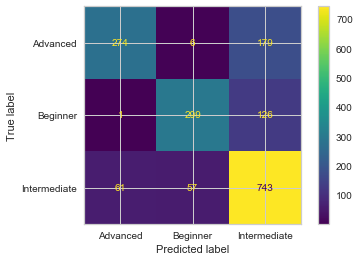

In [49]:
# Try micro 
eval_model(rf, X_train, X_test, y_train, y_test, ['Beginner', 'Intermediate', 'Advanced'], average='micro')

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


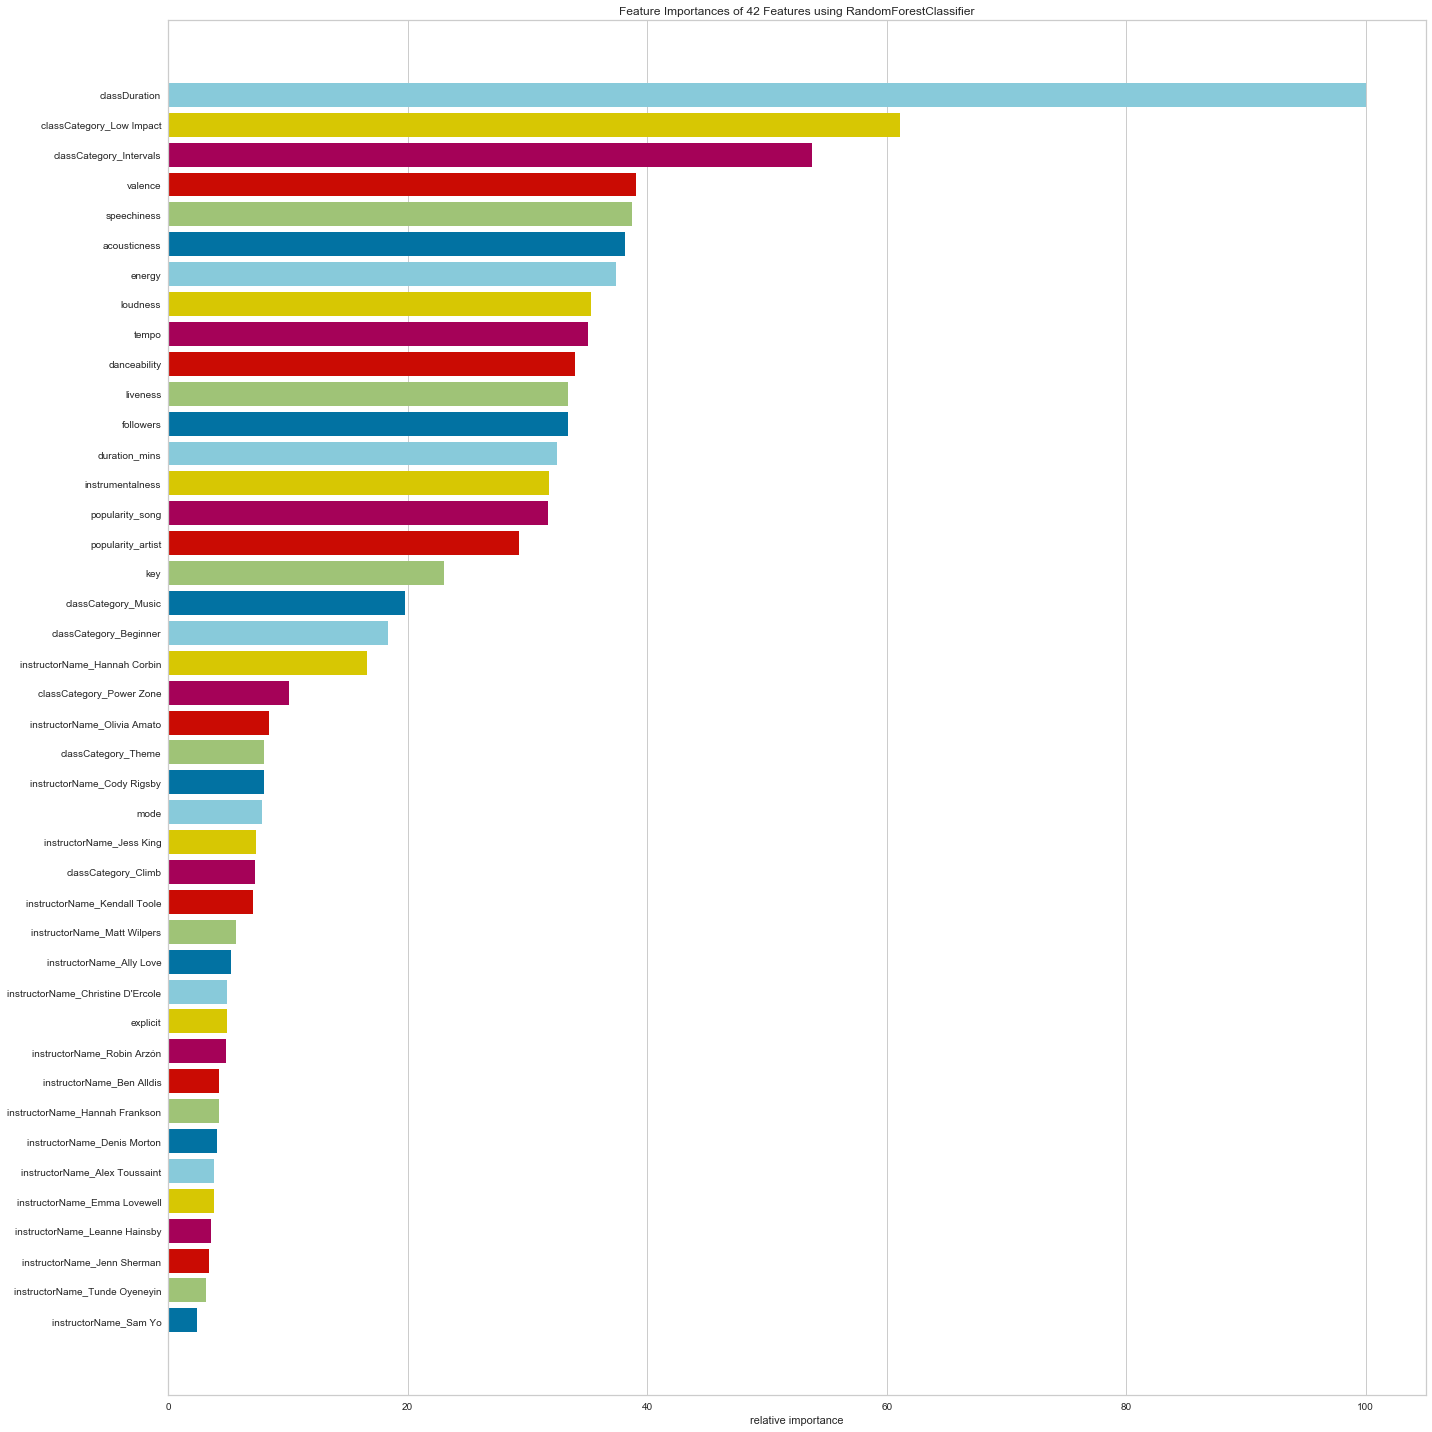

In [50]:
plt.figure(figsize=(20,20))
viz = FeatureImportances(rf)
viz.fit(X, y)
viz.show()

### Tuning RF

As a start, Randomized Search with a grid of hyperparameters that will be randomly sampled and then cross validated for each combination. Will use this to pare down the ranges in the grid values and then utilize Grid Search.

In [51]:
from sklearn.model_selection import RandomizedSearchCV

In [52]:
# # Source: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# print(random_grid)

In [53]:
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rfc = RandomForestClassifier()

In [54]:
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, 
#                                 cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring='f1_micro')
# # Fit the random search model
# rfc_random.fit(X_train, y_train)

In [55]:
# rfc_random.best_params_

In [56]:
# rfc_random.best_score_

### GridSearch

In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [58]:
# param_dict = {'n_estimators': [2000],
#                'max_features': ['auto'],
#                'max_depth': [55, 60, 65, 70],
#                'min_samples_split': [5, 10, 20, 30],
#                'min_samples_leaf': [1, 2, 4, 6],
#                'bootstrap': [True, False]}

# scorer = make_scorer(f1_score, average = 'micro')

In [59]:
# grid = GridSearchCV(rfc,
#                     param_grid = param_dict,
#                     scoring=scorer,
#                     cv=5,
#                     verbose=2)

# grid.fit(X_train, y_train)

In [60]:
# grid.best_params_

In [61]:
# grid.best_score_

#### Tuned RF Using Winning Parameters

In [62]:
tuned_rf = RandomForestClassifier(bootstrap = False,
                                  max_depth = 70,
                                  max_features = 'auto',
                                  min_samples_leaf = 1,
                                  min_samples_split = 20,
                                  n_estimators = 2000)

tuned_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=70, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

              precision    recall  f1-score   support

    Beginner       0.84      0.64      0.72       459
Intermediate       0.82      0.74      0.78       426
    Advanced       0.74      0.87      0.80       861

    accuracy                           0.78      1746
   macro avg       0.80      0.75      0.77      1746
weighted avg       0.78      0.78      0.77      1746

Train Scores
------------
Accuracy: 0.9728852396410158
F1 Score: 0.9728852396410158
--------------------
Test Scores
-----------
Accuracy: 0.7754868270332188
F1 Score: 0.7754868270332188
F1 Score Mean Cross Val 3-Fold: 0.7529115533280599


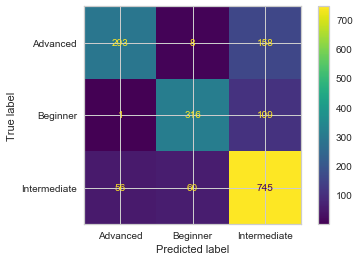

In [63]:
eval_model(tuned_rf, X_train, X_test, y_train, y_test, ['Beginner', 'Intermediate', 'Advanced'], average='micro')
# Still very overfit

              precision    recall  f1-score   support

    Beginner       0.84      0.64      0.72       459
Intermediate       0.82      0.74      0.78       426
    Advanced       0.74      0.87      0.80       861

    accuracy                           0.78      1746
   macro avg       0.80      0.75      0.77      1746
weighted avg       0.78      0.78      0.77      1746

Train Scores
------------
Accuracy: 0.9728852396410158
F1 Score: 0.9718927992441918
--------------------
Test Scores
-----------
Accuracy: 0.7754868270332188
F1 Score: 0.7667043934969149
F1 Score Mean Cross Val 3-Fold: 0.7399437991069568


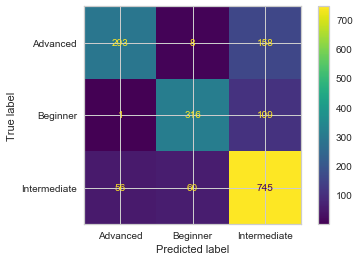

In [64]:
eval_model(tuned_rf, X_train, X_test, y_train, y_test, ['Beginner', 'Intermediate', 'Advanced'], average='macro')
# Still very overfit

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


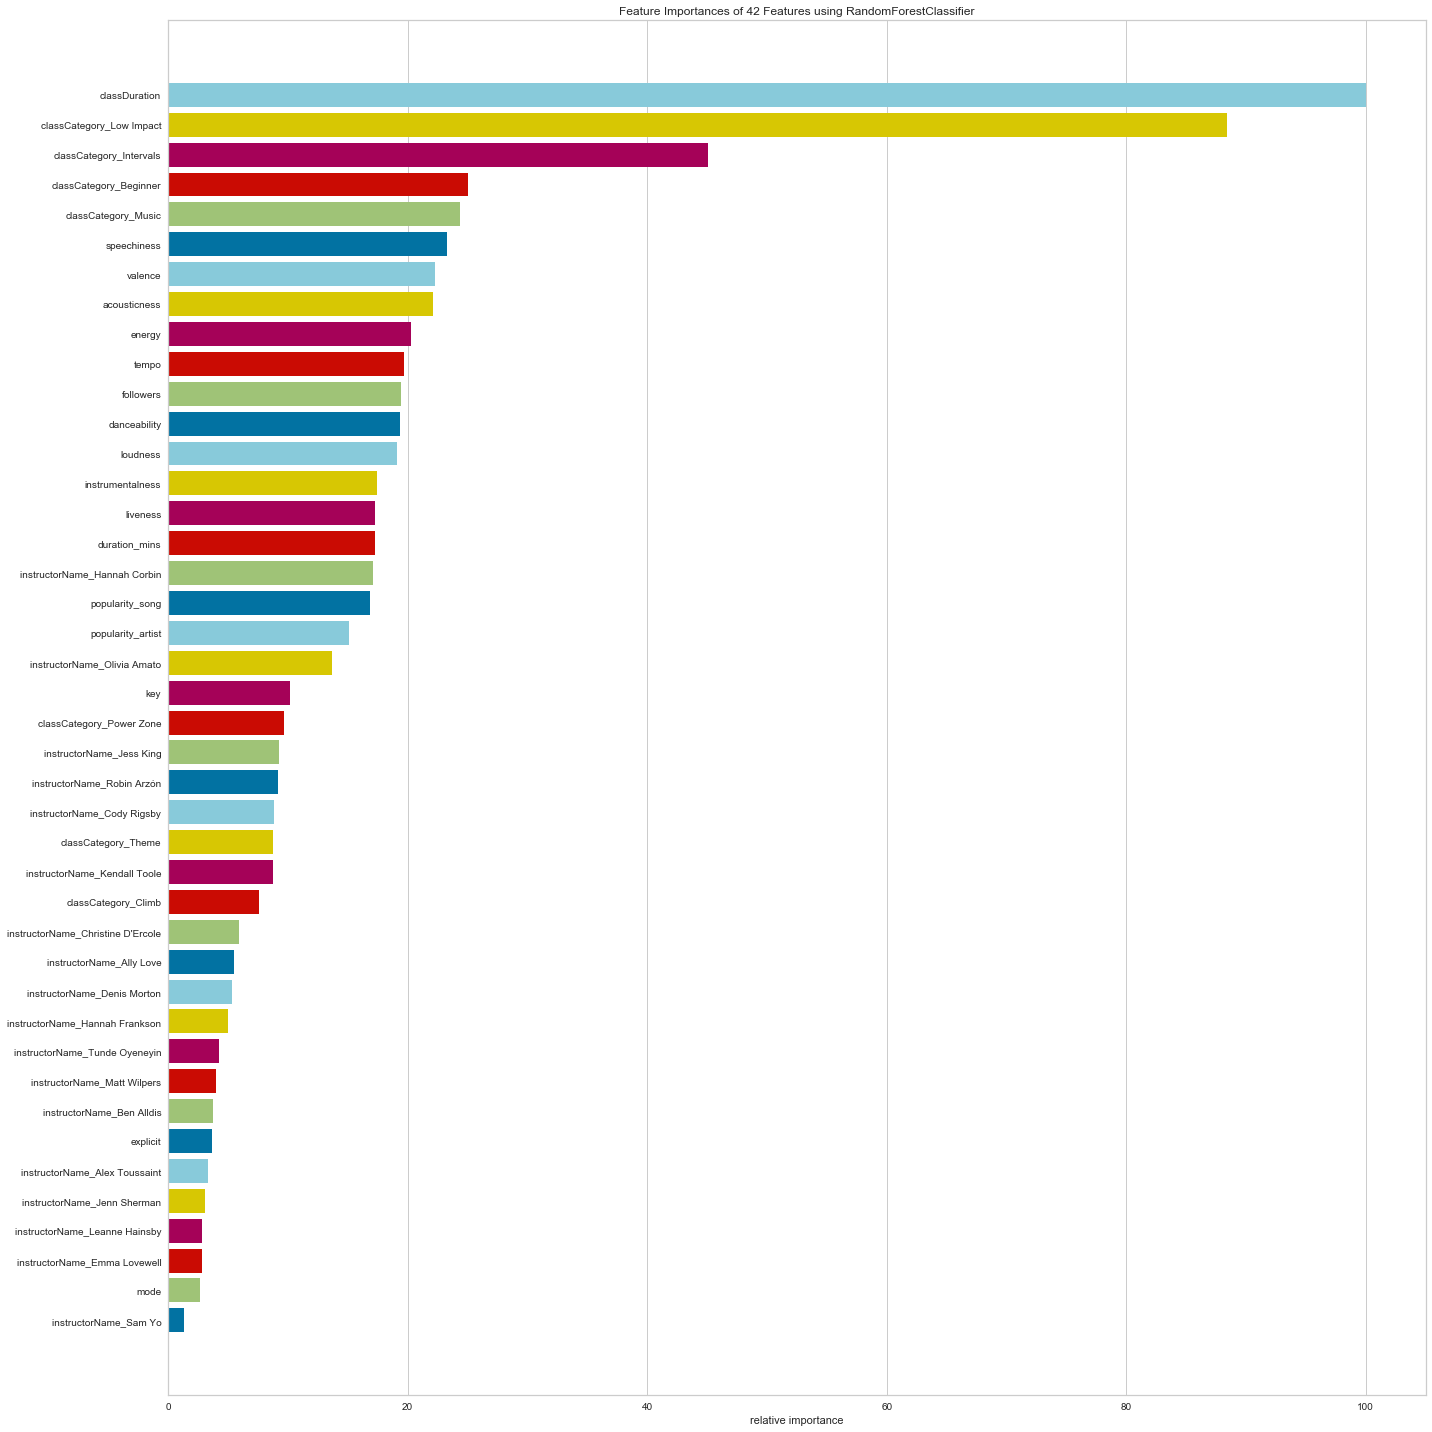

In [42]:
plt.figure(figsize=(20,20))
viz = FeatureImportances(tuned_rf)
viz.fit(X, y)
viz.show()
# same drivers

#### Random Forest Half Max Depth

In [45]:
tuned_rf2 = RandomForestClassifier(bootstrap = False,
                                  max_depth = 35,
                                  max_features = 'auto',
                                  min_samples_leaf = 1,
                                  min_samples_split = 20,
                                  n_estimators = 2000)

tuned_rf2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=35, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

              precision    recall  f1-score   support

    Beginner       0.83      0.63      0.72       459
Intermediate       0.83      0.74      0.78       426
    Advanced       0.73      0.86      0.79       861

    accuracy                           0.77      1746
   macro avg       0.80      0.74      0.76      1746
weighted avg       0.78      0.77      0.77      1746

Train Scores
------------
Accuracy: 0.9725033416077907
F1 Score: 0.9725033416077907
--------------------
Test Scores
-----------
Accuracy: 0.7720504009163803
F1 Score: 0.7720504009163803
F1 Score Mean Cross Val 3-Fold: 0.7527210783879322


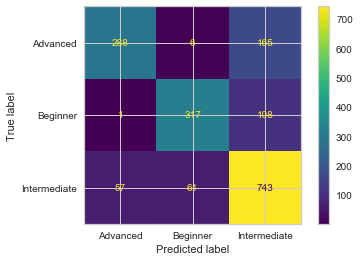

In [46]:
eval_model(tuned_rf2, X_train, X_test, y_train, y_test, ['Beginner', 'Intermediate', 'Advanced'], average='micro')
# Same stats as original tuned_rf... 

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


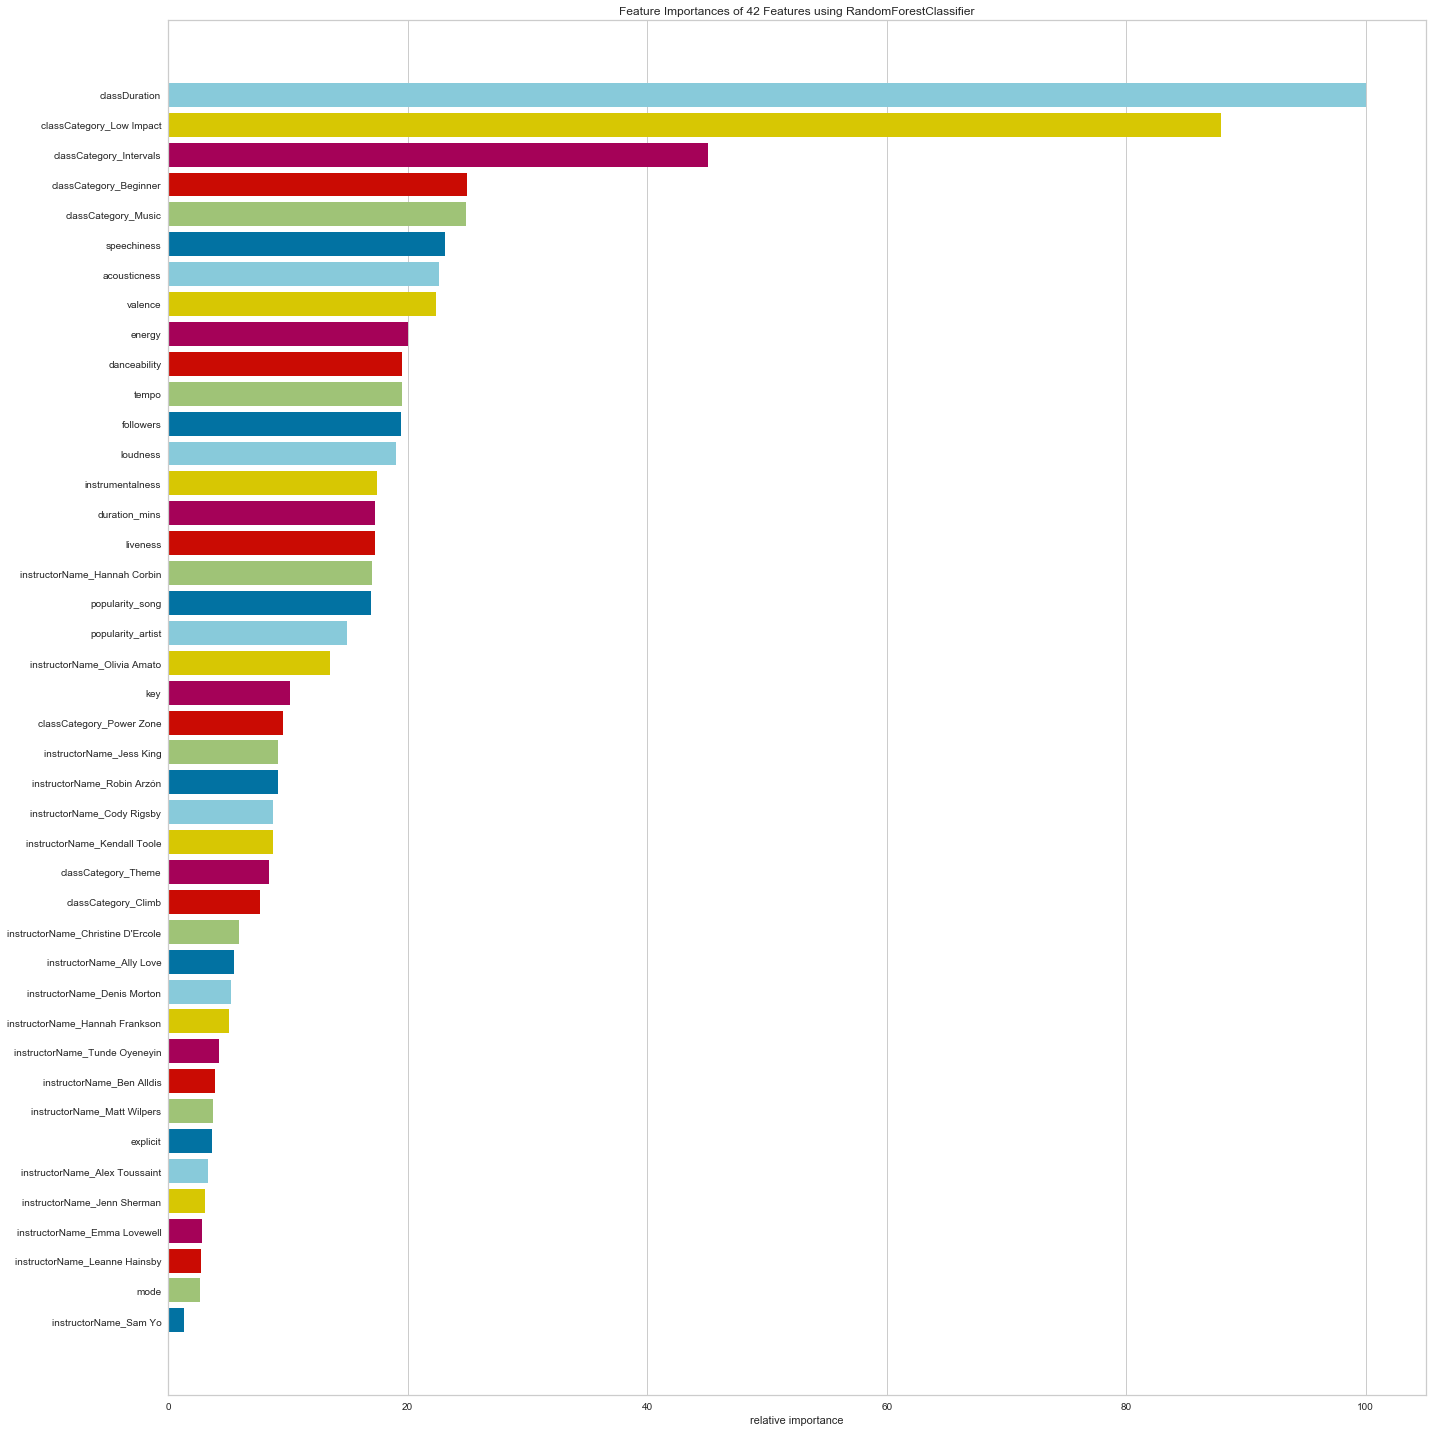

In [47]:
plt.figure(figsize=(20,20))
viz = FeatureImportances(tuned_rf2)
viz.fit(X, y)
viz.show()
# same drivers

#### Half max depth again

In [48]:
tuned_rf3 = RandomForestClassifier(bootstrap = False,
                                  max_depth = 17,
                                  max_features = 'auto',
                                  min_samples_leaf = 1,
                                  min_samples_split = 20,
                                  n_estimators = 2000)

tuned_rf3.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=17, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

              precision    recall  f1-score   support

    Beginner       0.84      0.60      0.70       459
Intermediate       0.84      0.71      0.77       426
    Advanced       0.72      0.88      0.79       861

    accuracy                           0.76      1746
   macro avg       0.80      0.73      0.75      1746
weighted avg       0.78      0.76      0.76      1746

Train Scores
------------
Accuracy: 0.9383234676341417
F1 Score: 0.9383234676341417
--------------------
Test Scores
-----------
Accuracy: 0.7640320733104238
F1 Score: 0.7640320733104238
F1 Score Mean Cross Val 3-Fold: 0.7523388156419202


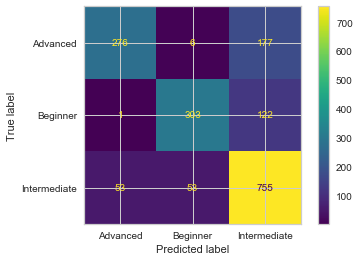

In [51]:
eval_model(tuned_rf3, X_train, X_test, y_train, y_test, ['Beginner', 'Intermediate', 'Advanced'], average='micro')
# Only slightly less overfit, starting to see less accuracy by .01
# move to play with max features

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


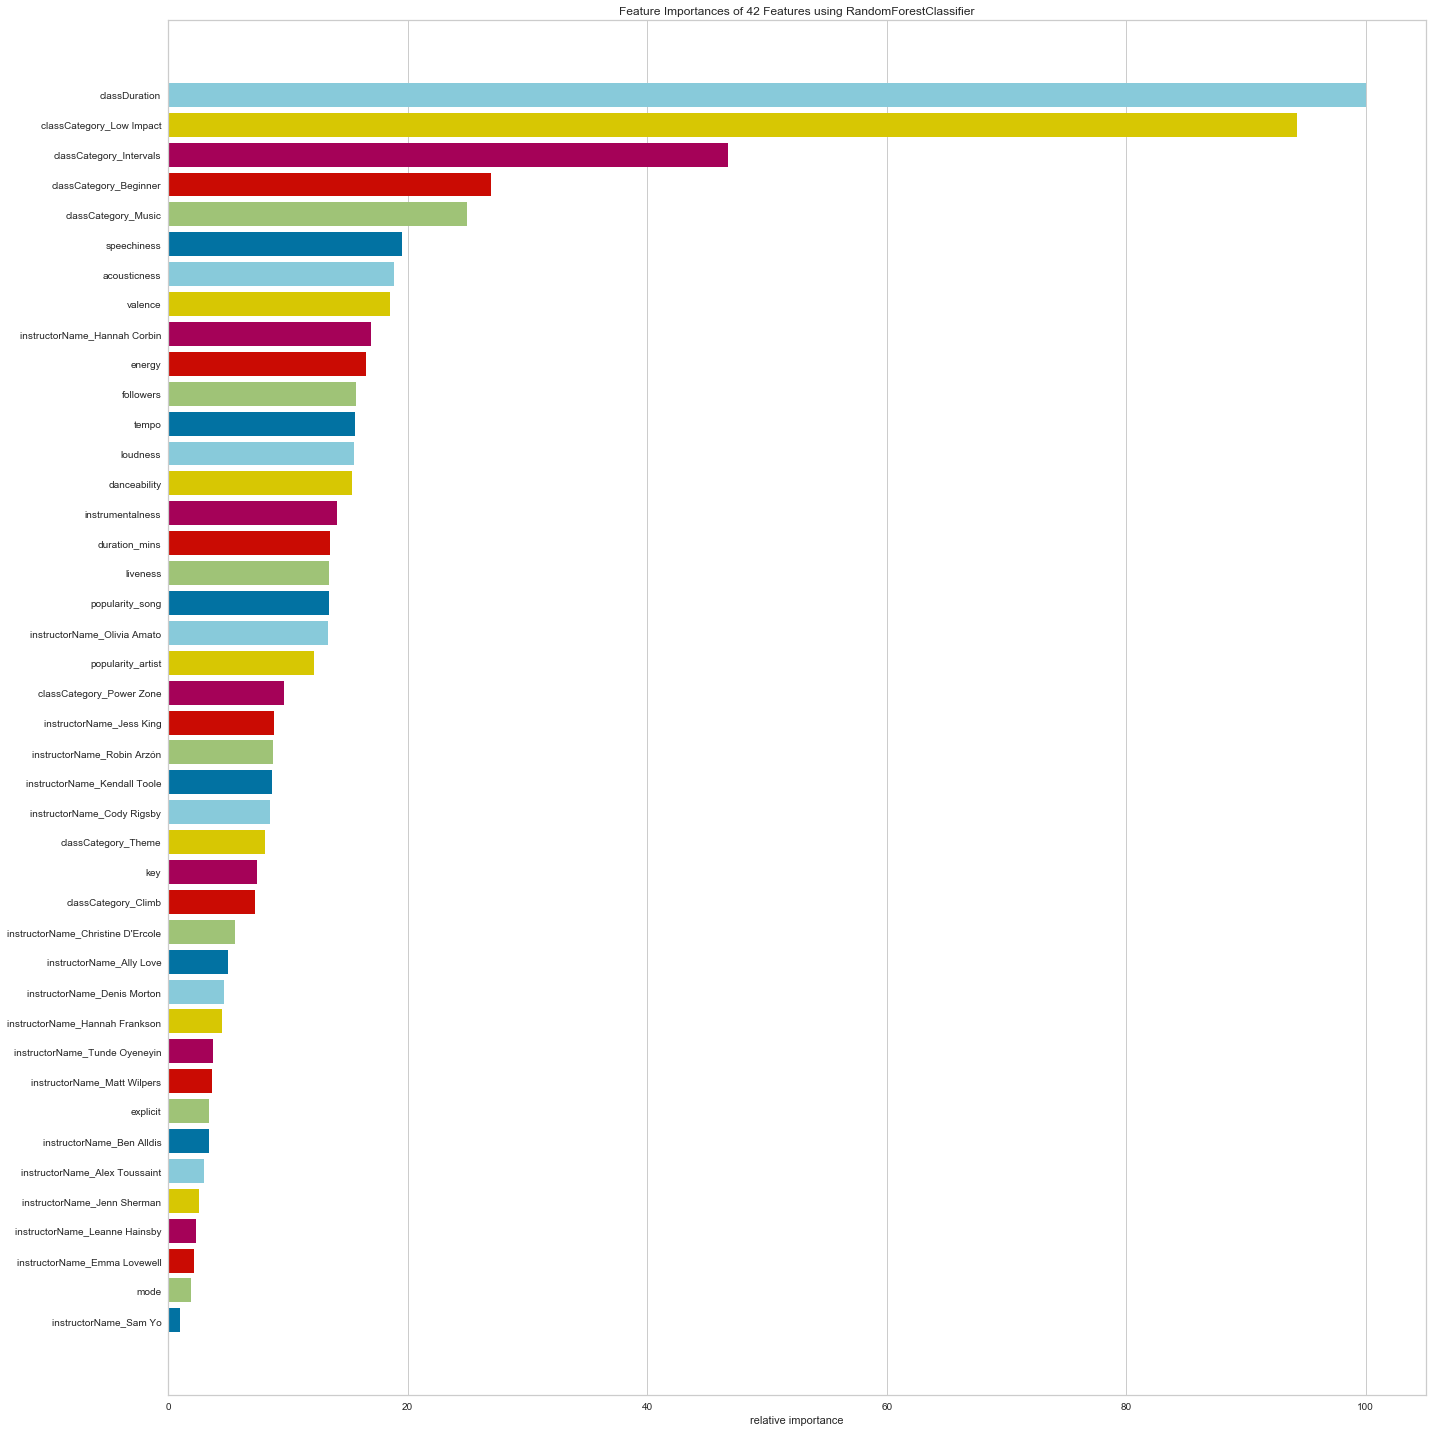

In [52]:
plt.figure(figsize=(20,20))
viz = FeatureImportances(tuned_rf3)
viz.fit(X, y)
viz.show()
# same drivers in top 5 ish
# Hannah Corbin instructure classes jumped in importance among half of music features

#### Tuning RF - Play with Max Features setting

In [54]:
len(X_train.columns)
# 42 features, try halfing

42

In [55]:
tuned_rf4 = RandomForestClassifier(bootstrap = False,
                                  max_depth = 17,
                                  max_features = 24,
                                  min_samples_leaf = 1,
                                  min_samples_split = 20,
                                  n_estimators = 2000)

tuned_rf4.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=17, max_features=24,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

              precision    recall  f1-score   support

    Beginner       0.77      0.67      0.72       459
Intermediate       0.82      0.77      0.79       426
    Advanced       0.74      0.82      0.78       861

    accuracy                           0.77      1746
   macro avg       0.78      0.75      0.76      1746
weighted avg       0.77      0.77      0.77      1746

Train Scores
------------
Accuracy: 0.9308764559862517
F1 Score: 0.9308764559862516
--------------------
Test Scores
-----------
Accuracy: 0.7668957617411226
F1 Score: 0.7668957617411227
F1 Score Mean Cross Val 3-Fold: 0.7479461856326536


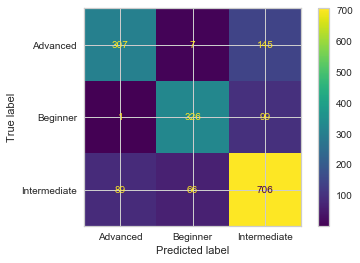

In [56]:
eval_model(tuned_rf4, X_train, X_test, y_train, y_test, ['Beginner', 'Intermediate', 'Advanced'], average='micro')
# Same as tuned_rf3...
# decrease max features again

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


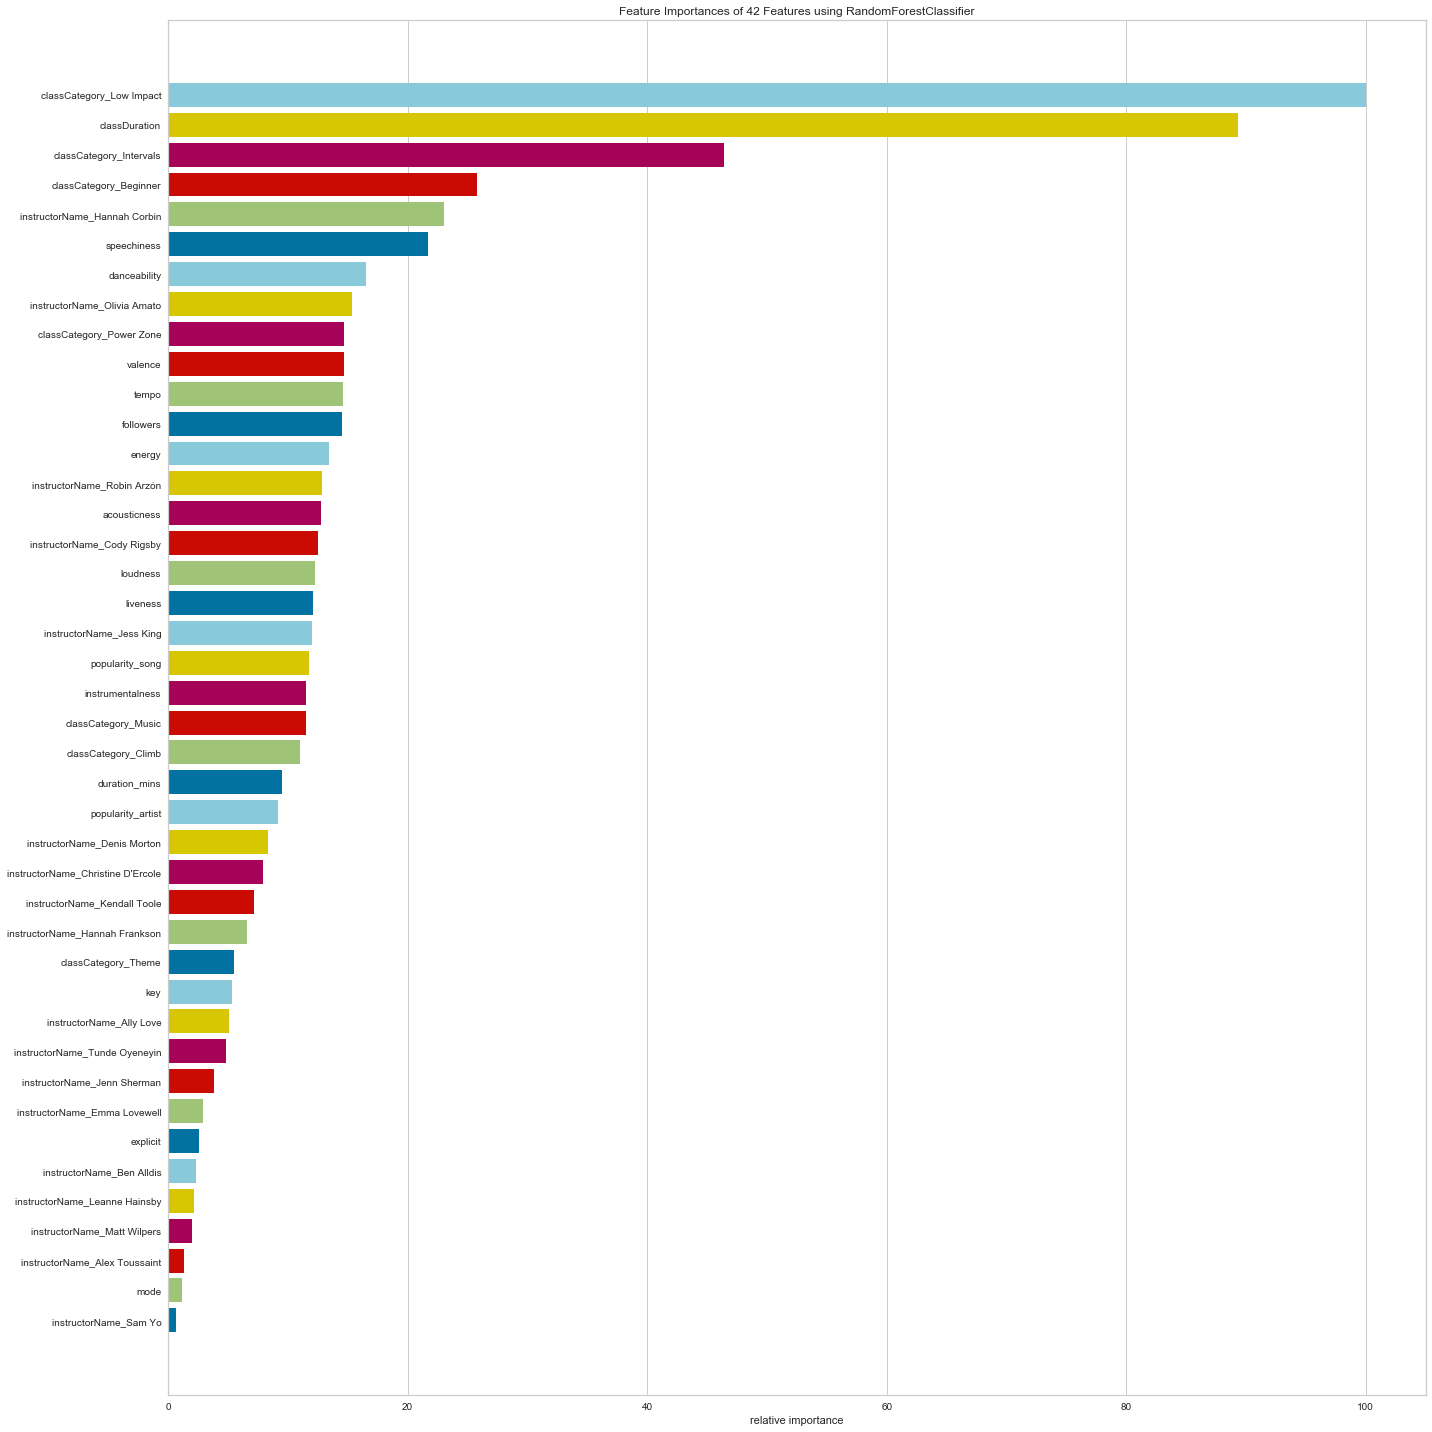

In [57]:
plt.figure(figsize=(20,20))
viz = FeatureImportances(tuned_rf4)
viz.fit(X, y)
viz.show()
# INTERESTING SWITCH
# Low impact is now highest driver instead of Duration
# Hannah Corbin classes as an instructor jumped above ALL music features
# Now Olivia instructed classes and Power Zone classed beat most music features

#### Tuning RF - Decrease max features again

In [58]:
len(X_train.columns)
# 42 features, try quartering

42

In [59]:
tuned_rf5 = RandomForestClassifier(bootstrap = False,
                                  max_depth = 17,
                                  max_features = 12,
                                  min_samples_leaf = 1,
                                  min_samples_split = 20,
                                  n_estimators = 2000)

tuned_rf5.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=17, max_features=12,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

              precision    recall  f1-score   support

    Beginner       0.82      0.66      0.73       459
Intermediate       0.83      0.76      0.79       426
    Advanced       0.74      0.85      0.79       861

    accuracy                           0.78      1746
   macro avg       0.80      0.76      0.77      1746
weighted avg       0.78      0.78      0.78      1746

Train Scores
------------
Accuracy: 0.9381325186175291
F1 Score: 0.9381325186175291
--------------------
Test Scores
-----------
Accuracy: 0.777205040091638
F1 Score: 0.7772050400916379
F1 Score Mean Cross Val 3-Fold: 0.7582592931749579


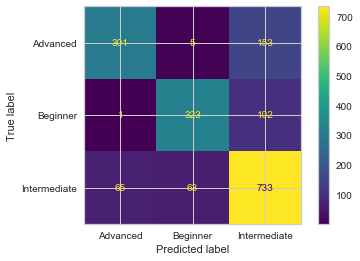

In [60]:
eval_model(tuned_rf5, X_train, X_test, y_train, y_test, ['Beginner', 'Intermediate', 'Advanced'], average='micro')
# still overfit
# f1 back up to 77

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


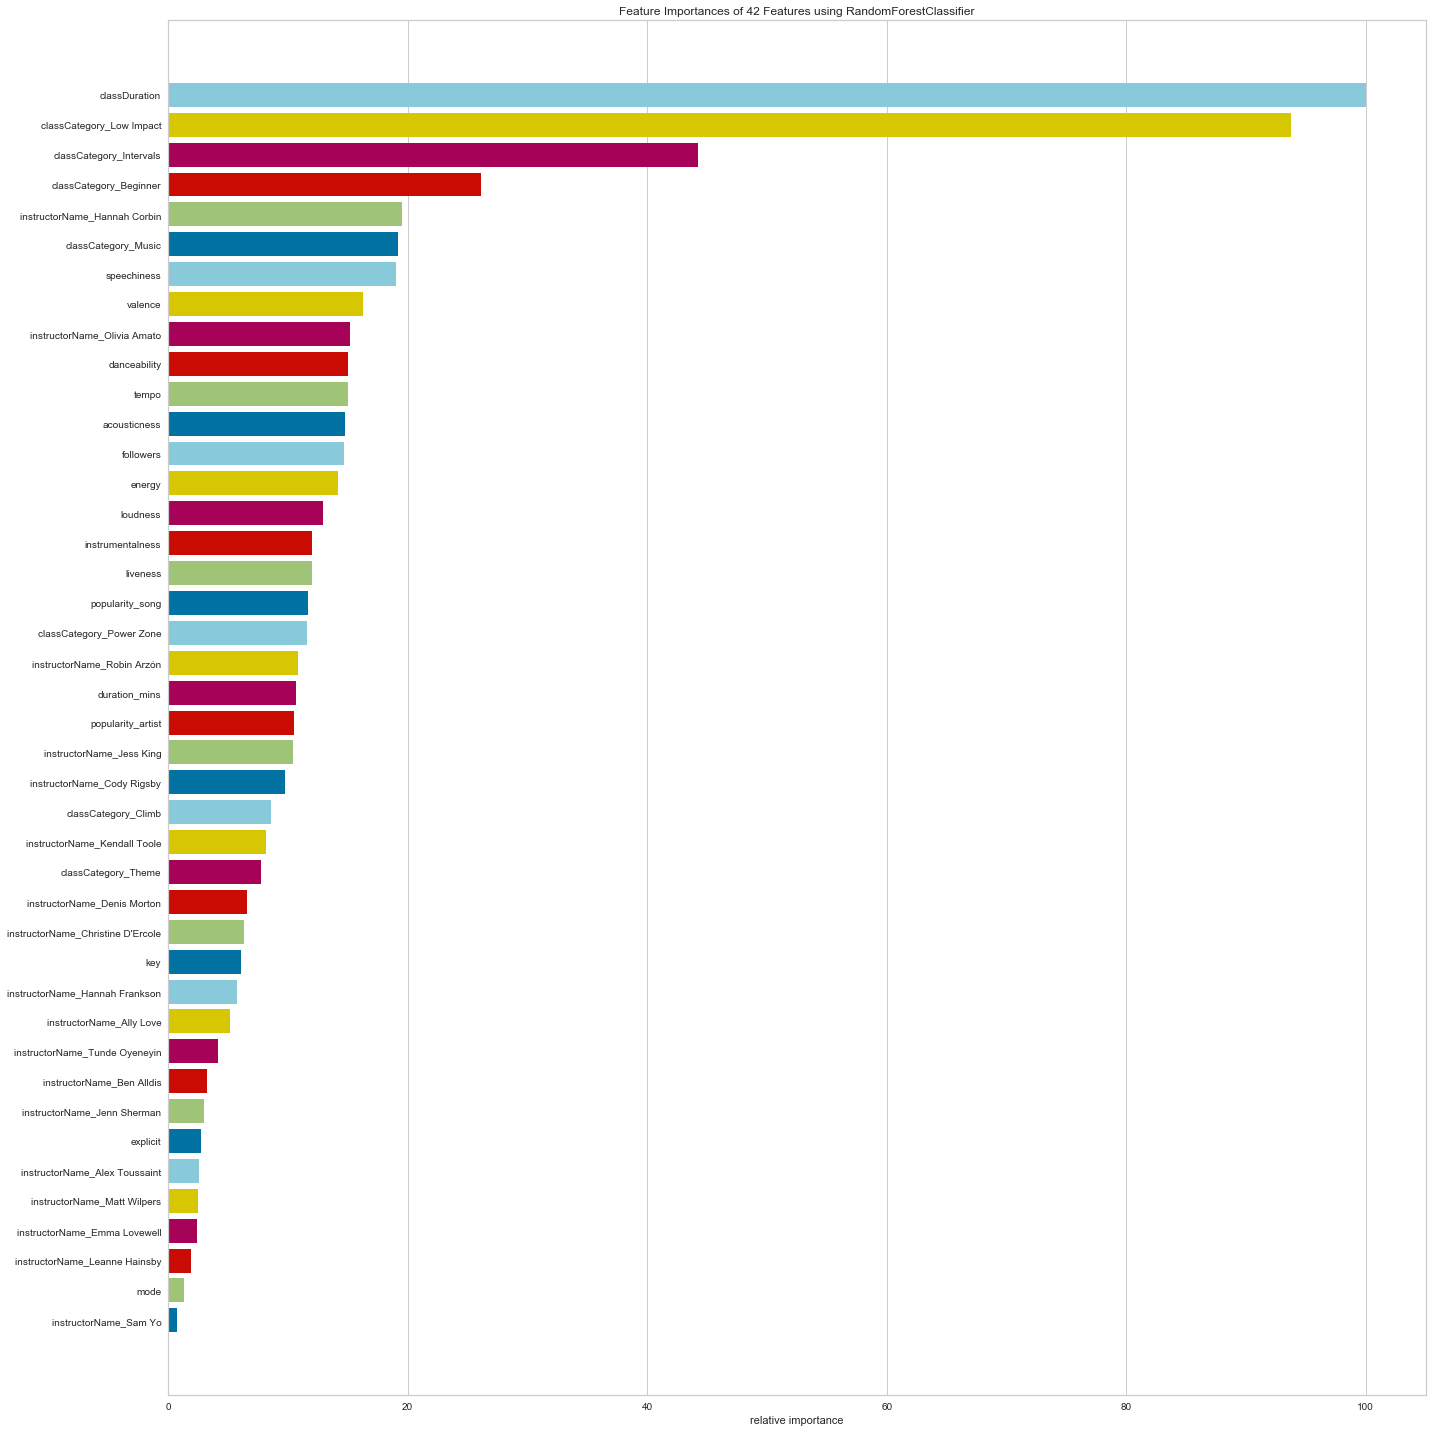

In [61]:
plt.figure(figsize=(20,20))
viz = FeatureImportances(tuned_rf5)
viz.fit(X, y)
viz.show()
# same drivers as rf4

#### Tuning RF - Decrease max features Round 3

In [63]:
tuned_rf6 = RandomForestClassifier(bootstrap = False,
                                  max_depth = 17,
                                  max_features = 6,
                                  min_samples_leaf = 1,
                                  min_samples_split = 20,
                                  n_estimators = 2000)

tuned_rf6.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=17, max_features=6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

              precision    recall  f1-score   support

    Beginner       0.84      0.61      0.70       459
Intermediate       0.84      0.72      0.77       426
    Advanced       0.72      0.88      0.79       861

    accuracy                           0.77      1746
   macro avg       0.80      0.73      0.76      1746
weighted avg       0.78      0.77      0.76      1746

Train Scores
------------
Accuracy: 0.9369868245178538
F1 Score: 0.9369868245178538
--------------------
Test Scores
-----------
Accuracy: 0.7663230240549829
F1 Score: 0.7663230240549829
F1 Score Mean Cross Val 3-Fold: 0.7519572093287864


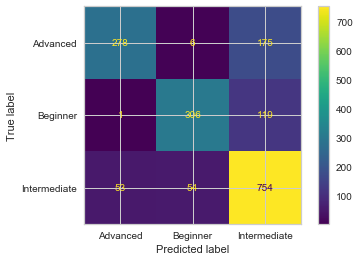

In [64]:
eval_model(tuned_rf6, X_train, X_test, y_train, y_test, ['Beginner', 'Intermediate', 'Advanced'], average='micro')
# still overfit...
# f1 back down to 76

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


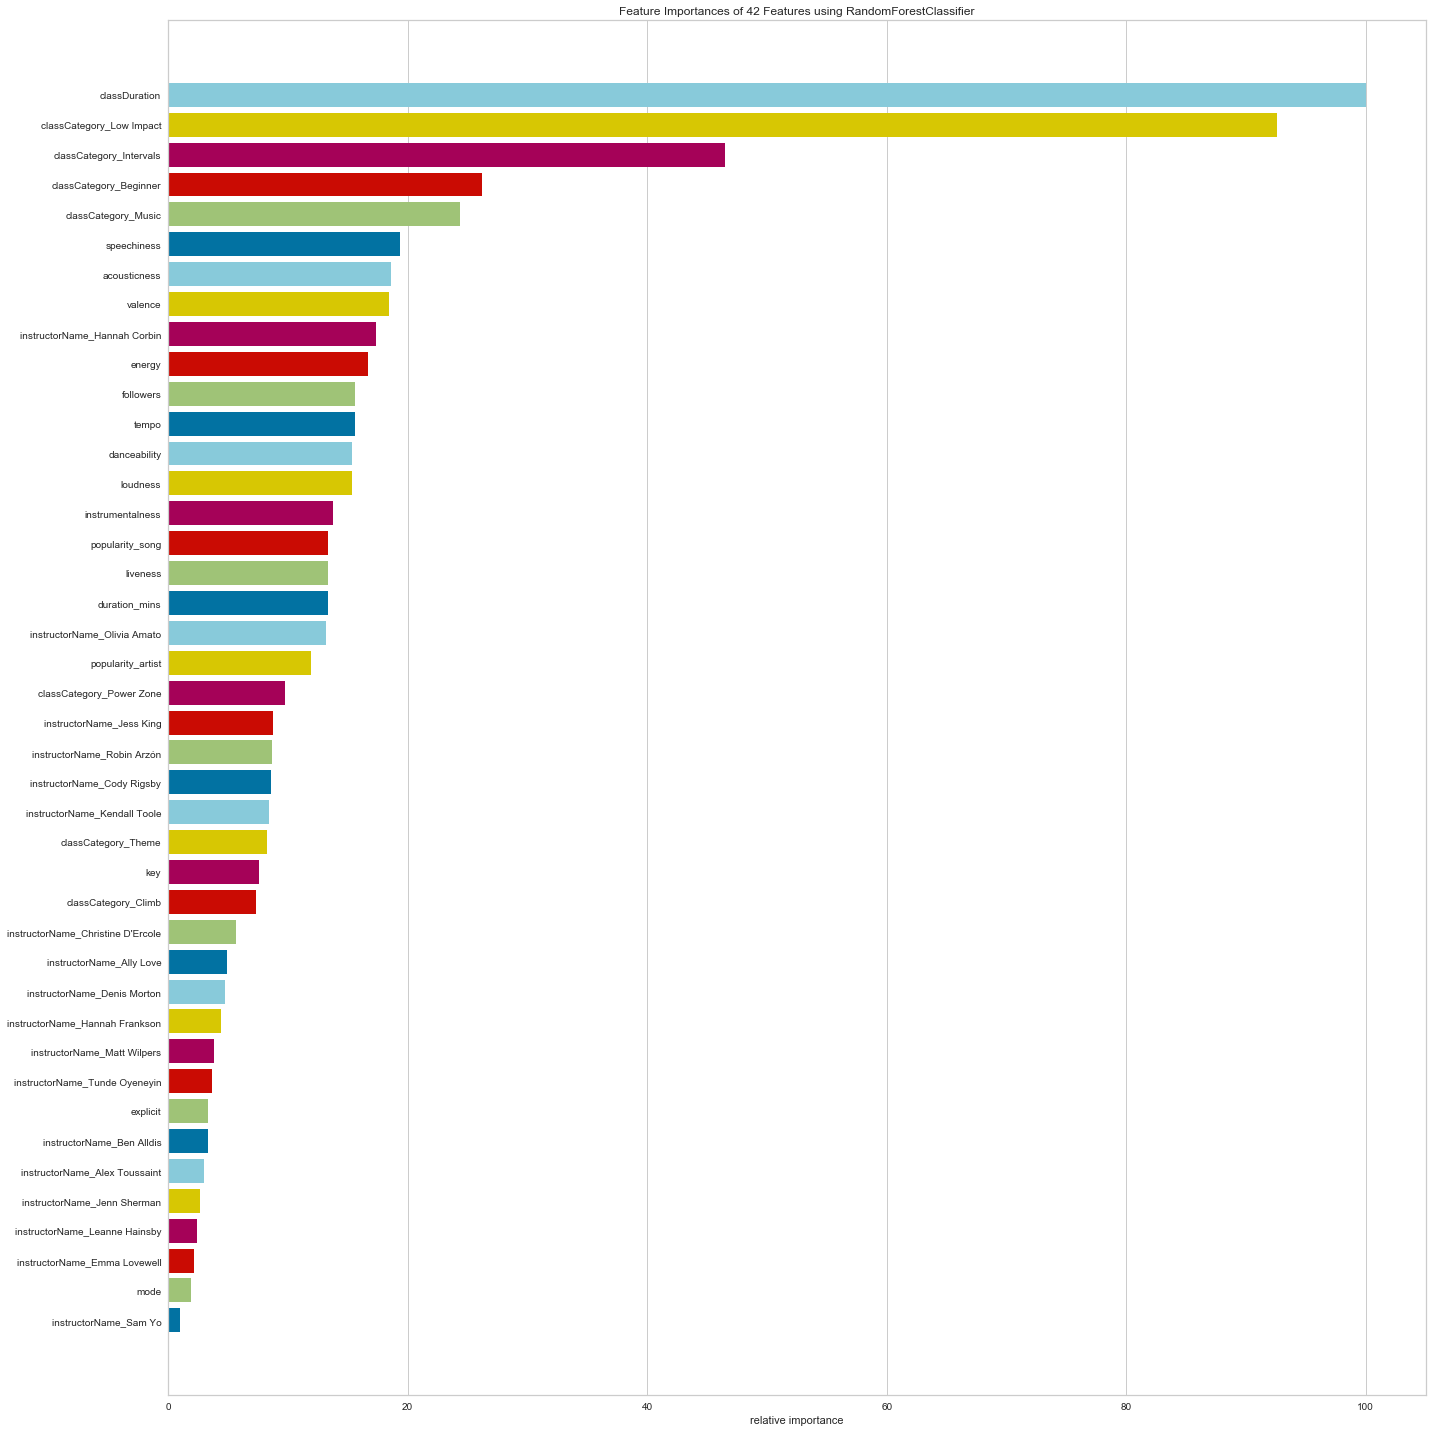

In [65]:
plt.figure(figsize=(20,20))
viz = FeatureImportances(tuned_rf6)
viz.fit(X, y)
viz.show()

#### Tuning RF - Keep max features = 12 (highest acc and f1), go back to decreasing max depth

In [66]:
tuned_rf7 = RandomForestClassifier(bootstrap = False,
                                  max_depth = 9,
                                  max_features = 12,
                                  min_samples_leaf = 1,
                                  min_samples_split = 20,
                                  n_estimators = 2000)

tuned_rf7.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features=12,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

              precision    recall  f1-score   support

    Beginner       0.88      0.51      0.65       459
Intermediate       0.84      0.68      0.75       426
    Advanced       0.69      0.91      0.78       861

    accuracy                           0.75      1746
   macro avg       0.80      0.70      0.73      1746
weighted avg       0.78      0.75      0.74      1746

Train Scores
------------
Accuracy: 0.8103876265037235
F1 Score: 0.8103876265037235
--------------------
Test Scores
-----------
Accuracy: 0.7485681557846506
F1 Score: 0.7485681557846506
F1 Score Mean Cross Val 3-Fold: 0.7376362508492601


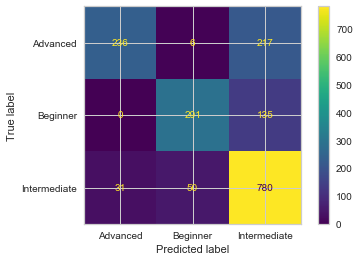

In [67]:
eval_model(tuned_rf7, X_train, X_test, y_train, y_test, ['Beginner', 'Intermediate', 'Advanced'], average='micro')
# LESS OVERFIT! Play more with Max Features!
# Acc + F1 down to .74, but still good overall.

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


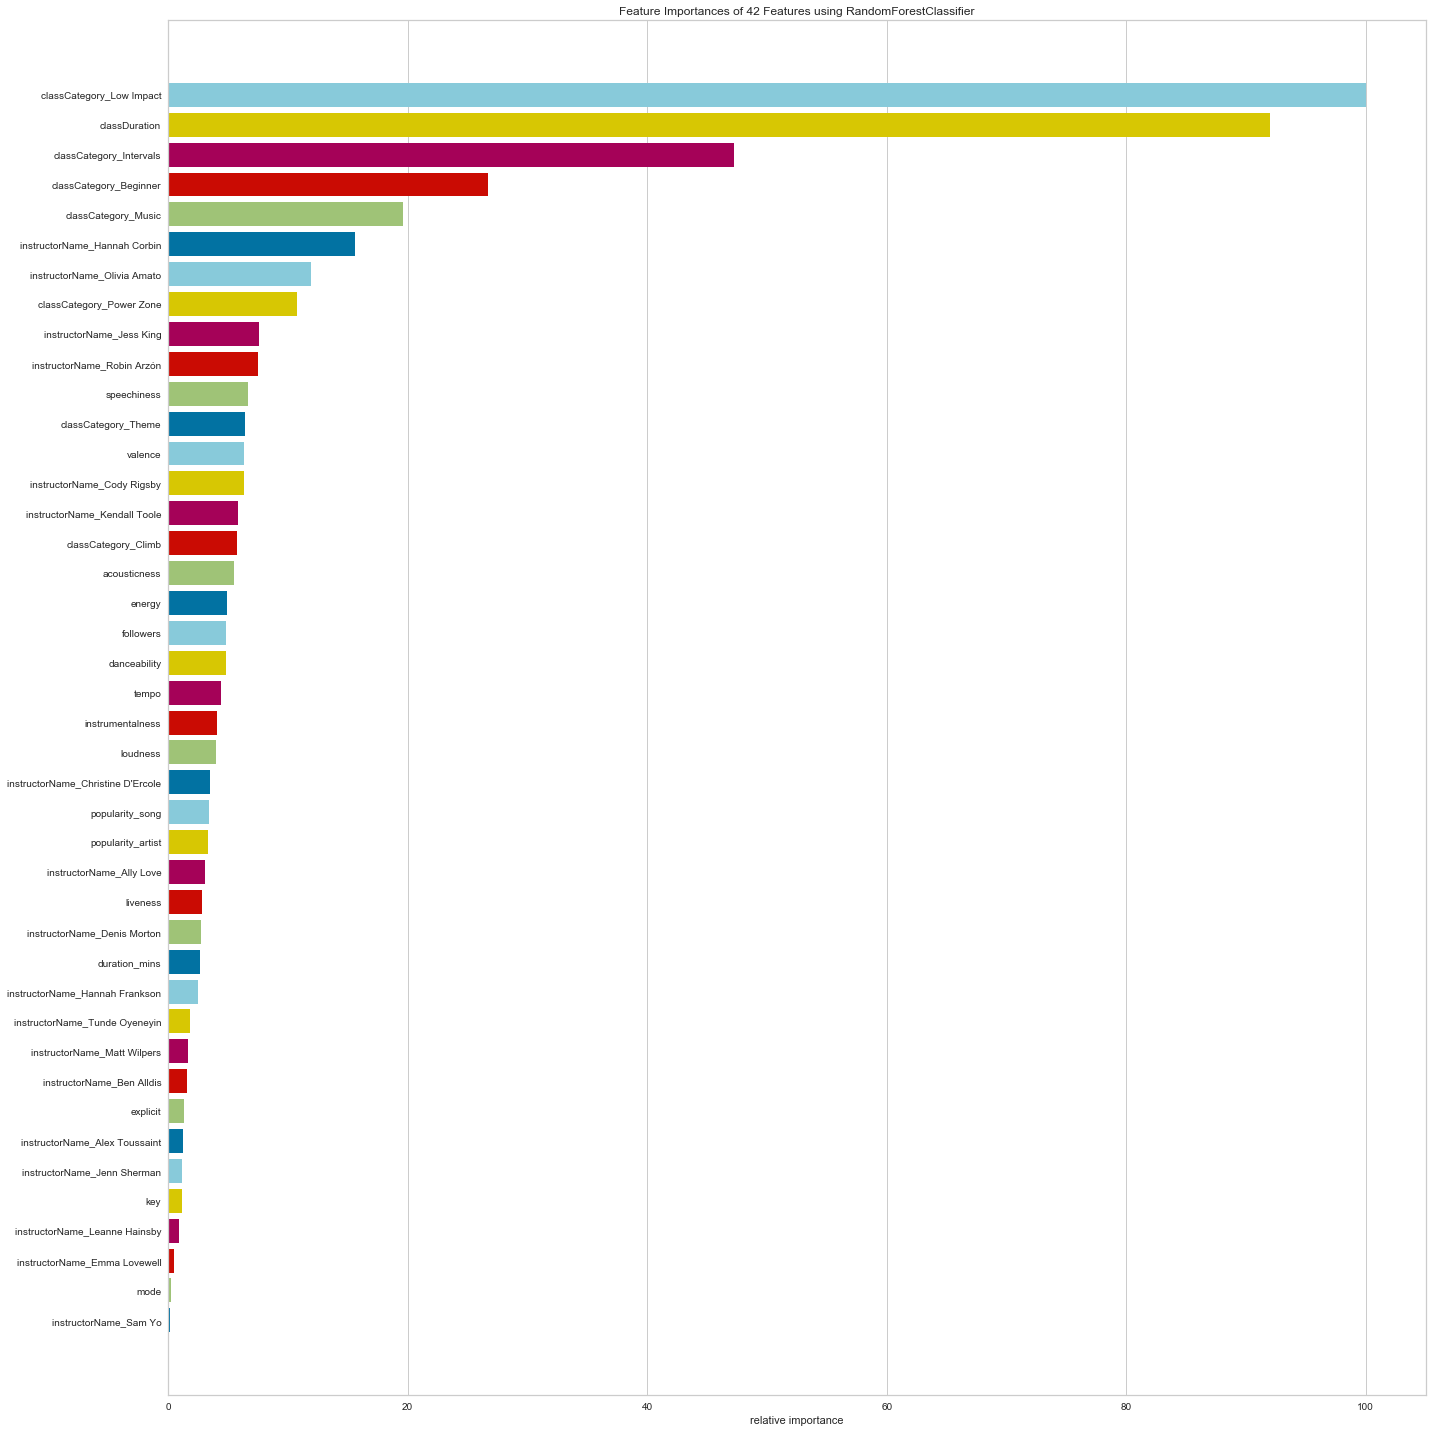

In [68]:
plt.figure(figsize=(20,20))
viz = FeatureImportances(tuned_rf7)
viz.fit(X, y)
viz.show()

#### Tuning RF - Decrease max features Round 3

In [63]:
tuned_rf6 = RandomForestClassifier(bootstrap = False,
                                  max_depth = 17,
                                  max_features = 6,
                                  min_samples_leaf = 1,
                                  min_samples_split = 20,
                                  n_estimators = 2000)

tuned_rf6.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=17, max_features=6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

              precision    recall  f1-score   support

    Beginner       0.84      0.61      0.70       459
Intermediate       0.84      0.72      0.77       426
    Advanced       0.72      0.88      0.79       861

    accuracy                           0.77      1746
   macro avg       0.80      0.73      0.76      1746
weighted avg       0.78      0.77      0.76      1746

Train Scores
------------
Accuracy: 0.9369868245178538
F1 Score: 0.9369868245178538
--------------------
Test Scores
-----------
Accuracy: 0.7663230240549829
F1 Score: 0.7663230240549829
F1 Score Mean Cross Val 3-Fold: 0.7519572093287864


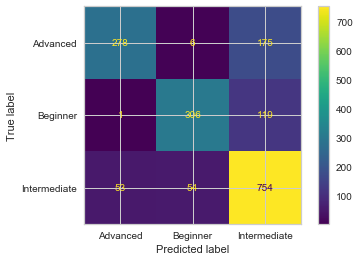

In [64]:
eval_model(tuned_rf6, X_train, X_test, y_train, y_test, ['Beginner', 'Intermediate', 'Advanced'], average='micro')
# still overfit...
# f1 back down to 76

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


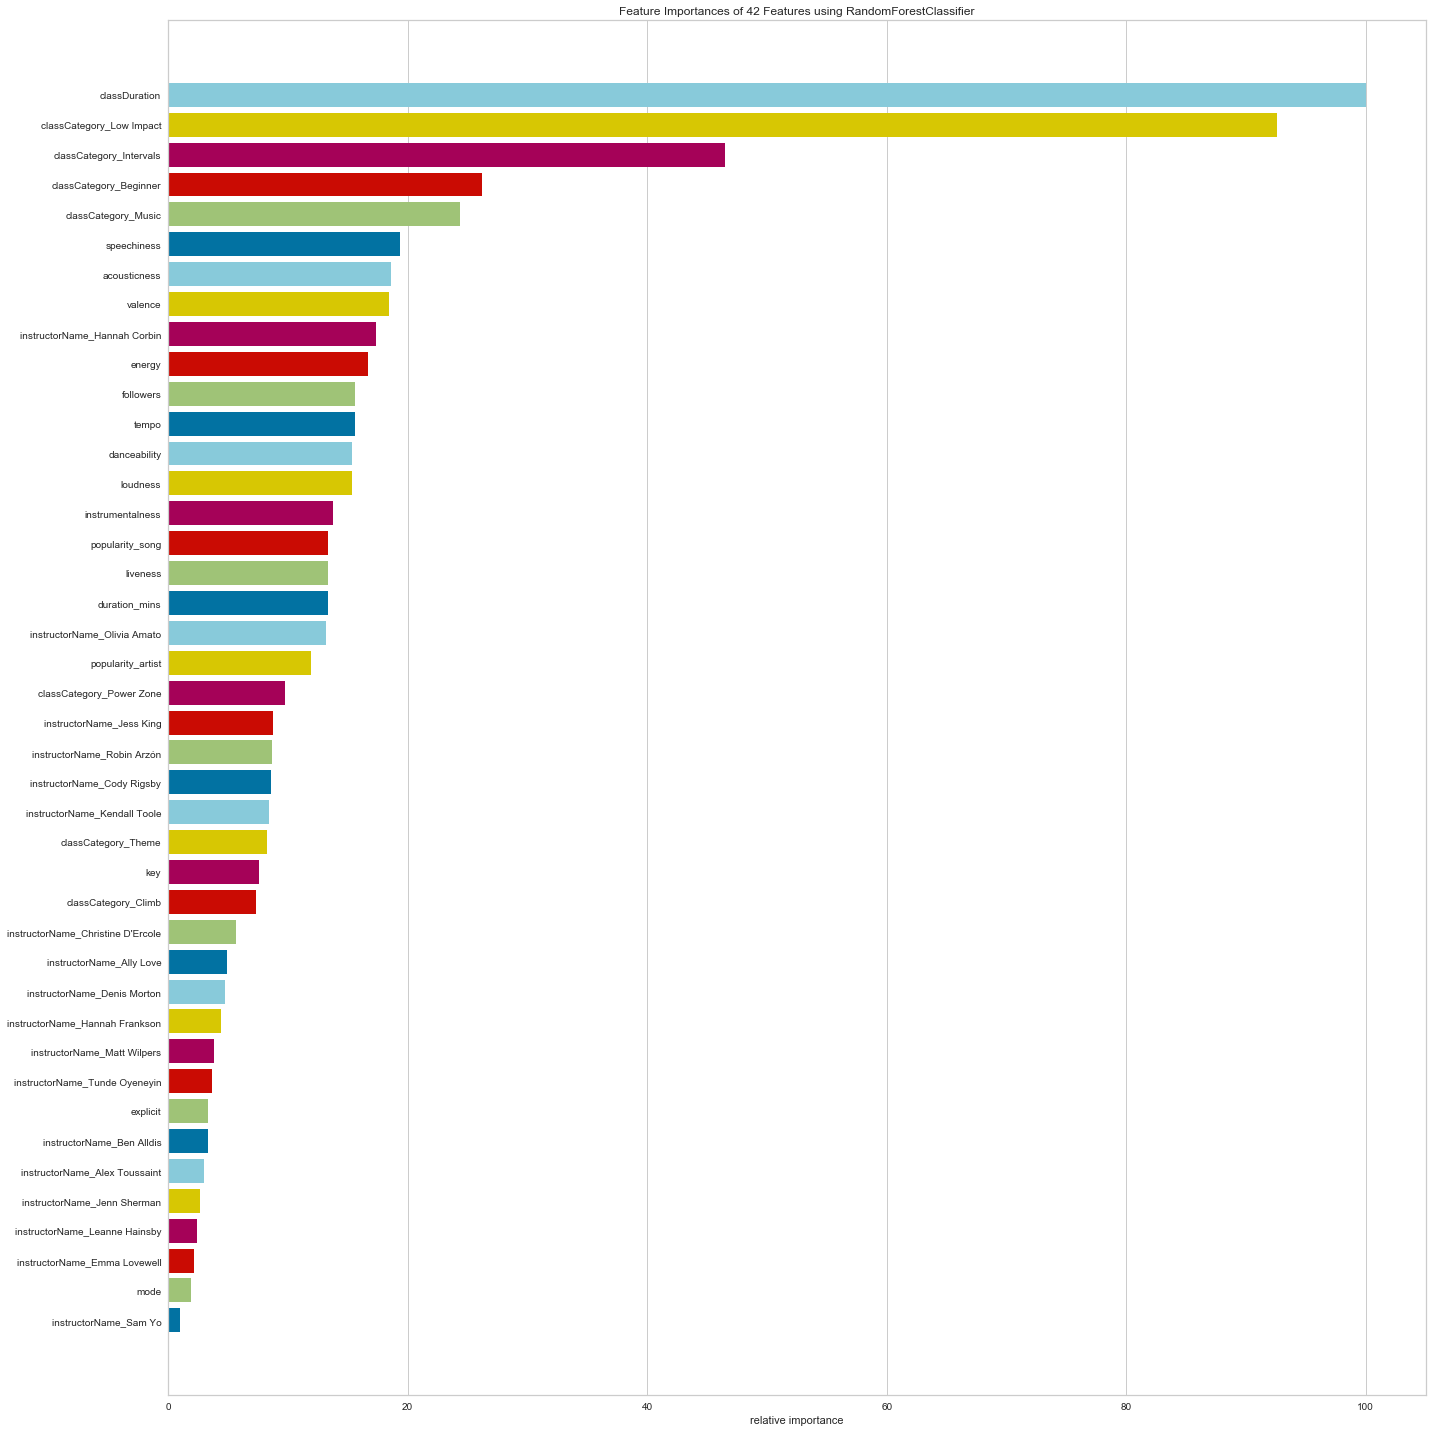

In [65]:
plt.figure(figsize=(20,20))
viz = FeatureImportances(tuned_rf6)
viz.fit(X, y)
viz.show()

#### Tuning RF - Keep max features = 12 (highest acc and f1), go back to decreasing max depth

In [66]:
tuned_rf7 = RandomForestClassifier(bootstrap = False,
                                  max_depth = 9,
                                  max_features = 12,
                                  min_samples_leaf = 1,
                                  min_samples_split = 20,
                                  n_estimators = 2000)

tuned_rf7.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features=12,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

              precision    recall  f1-score   support

    Beginner       0.88      0.51      0.65       459
Intermediate       0.84      0.68      0.75       426
    Advanced       0.69      0.91      0.78       861

    accuracy                           0.75      1746
   macro avg       0.80      0.70      0.73      1746
weighted avg       0.78      0.75      0.74      1746

Train Scores
------------
Accuracy: 0.8103876265037235
F1 Score: 0.8103876265037235
--------------------
Test Scores
-----------
Accuracy: 0.7485681557846506
F1 Score: 0.7485681557846506
F1 Score Mean Cross Val 3-Fold: 0.7376362508492601


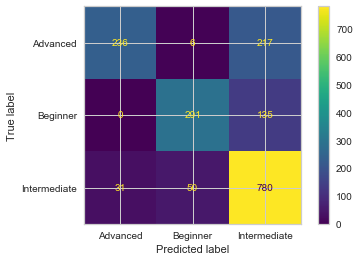

In [67]:
eval_model(tuned_rf7, X_train, X_test, y_train, y_test, ['Beginner', 'Intermediate', 'Advanced'], average='micro')
# LESS OVERFIT! Play more with Max Features!
# Acc + F1 down to .74, but still good overall.

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


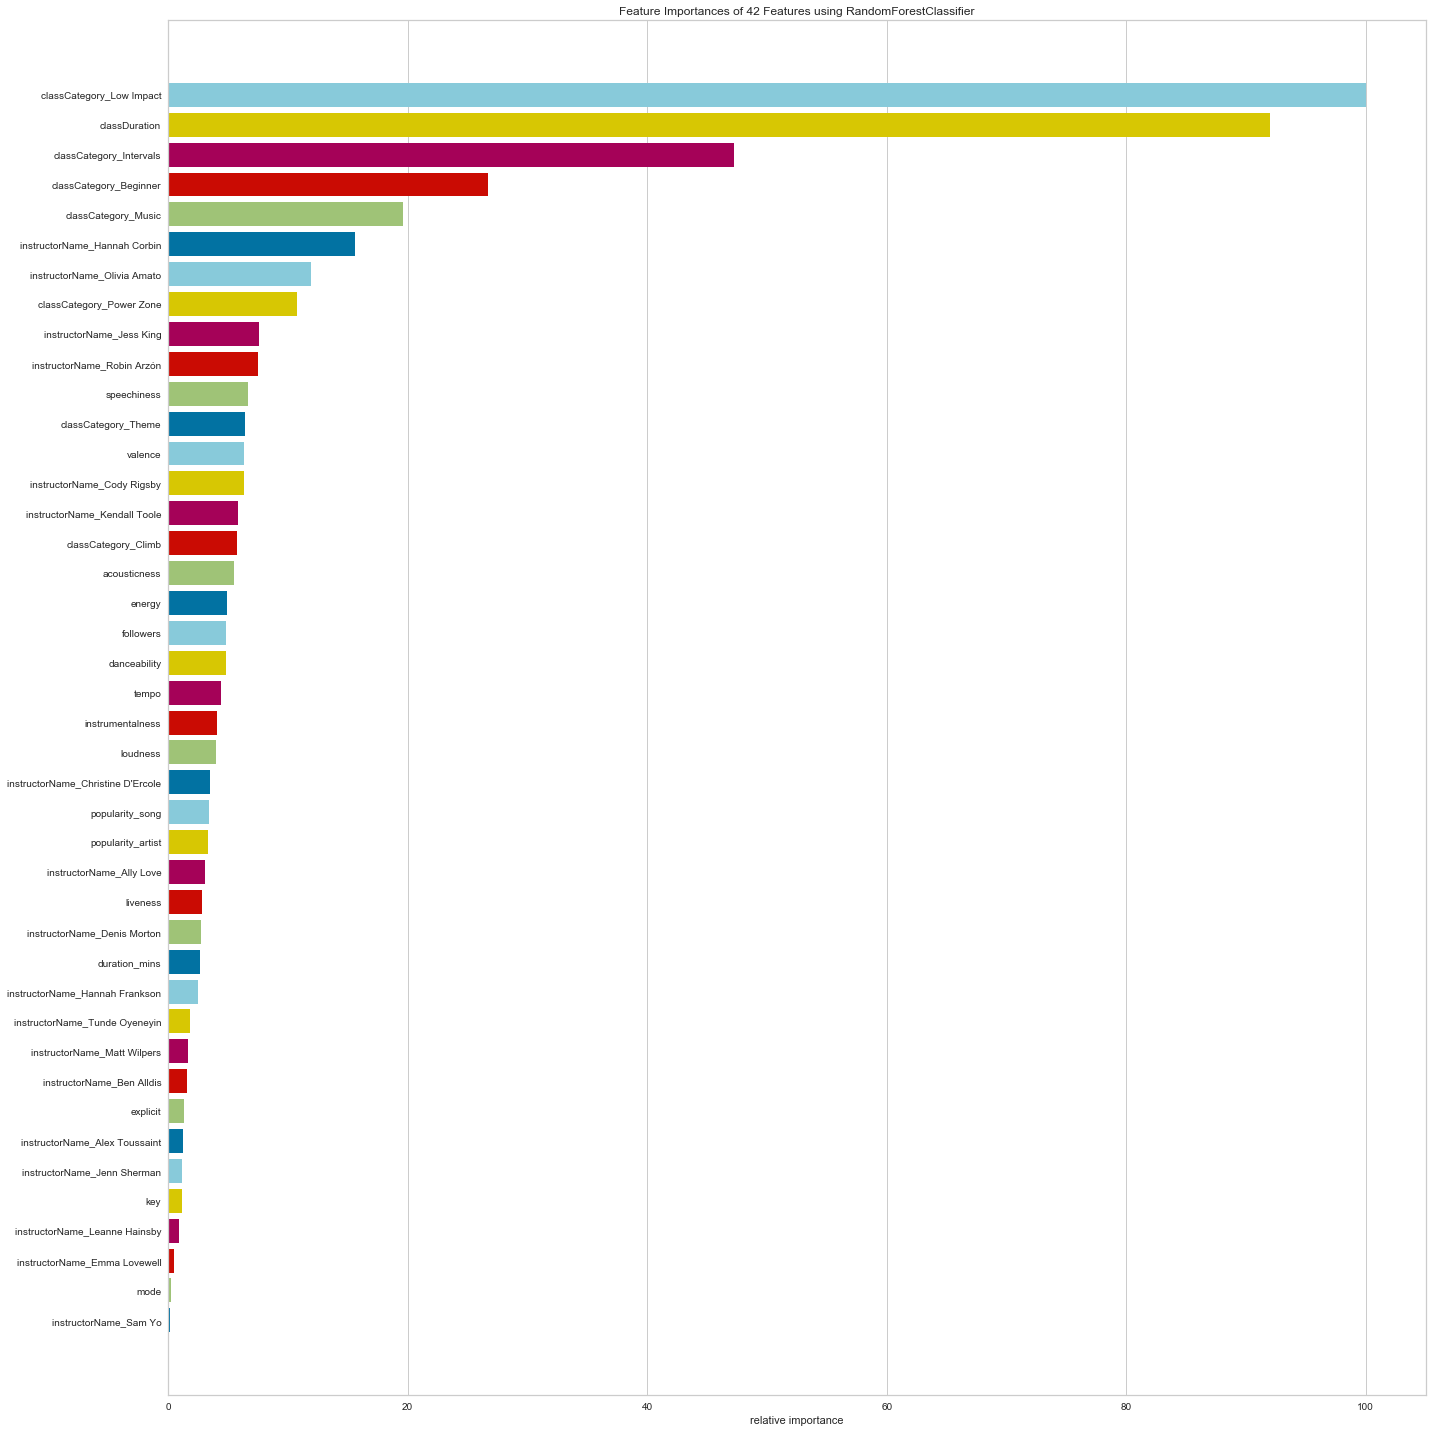

In [68]:
plt.figure(figsize=(20,20))
viz = FeatureImportances(tuned_rf7)
viz.fit(X, y)
viz.show()

#### Tuning RF - Keep back to decreasing max depth (half again) to address overfitting

In [69]:
tuned_rf8 = RandomForestClassifier(bootstrap = False,
                                  max_depth = 9,
                                  max_features = 6,
                                  min_samples_leaf = 1,
                                  min_samples_split = 20,
                                  n_estimators = 2000)

tuned_rf8.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features=6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

              precision    recall  f1-score   support

    Beginner       0.88      0.43      0.58       459
Intermediate       0.89      0.57      0.69       426
    Advanced       0.65      0.94      0.76       861

    accuracy                           0.71      1746
   macro avg       0.81      0.65      0.68      1746
weighted avg       0.77      0.71      0.70      1746

Train Scores
------------
Accuracy: 0.7890013366431163
F1 Score: 0.7890013366431163
--------------------
Test Scores
-----------
Accuracy: 0.7142038946162658
F1 Score: 0.7142038946162658
F1 Score Mean Cross Val 3-Fold: 0.7076572895230031


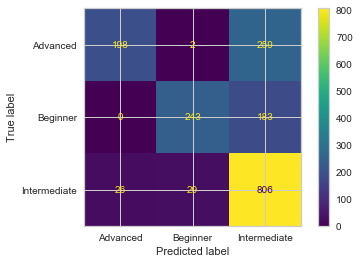

In [70]:
eval_model(tuned_rf8, X_train, X_test, y_train, y_test, ['Beginner', 'Intermediate', 'Advanced'], average='micro')
# Less overfit but acc and f1 down
# Try higher max features between 6 and 12 and increase max depth again

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


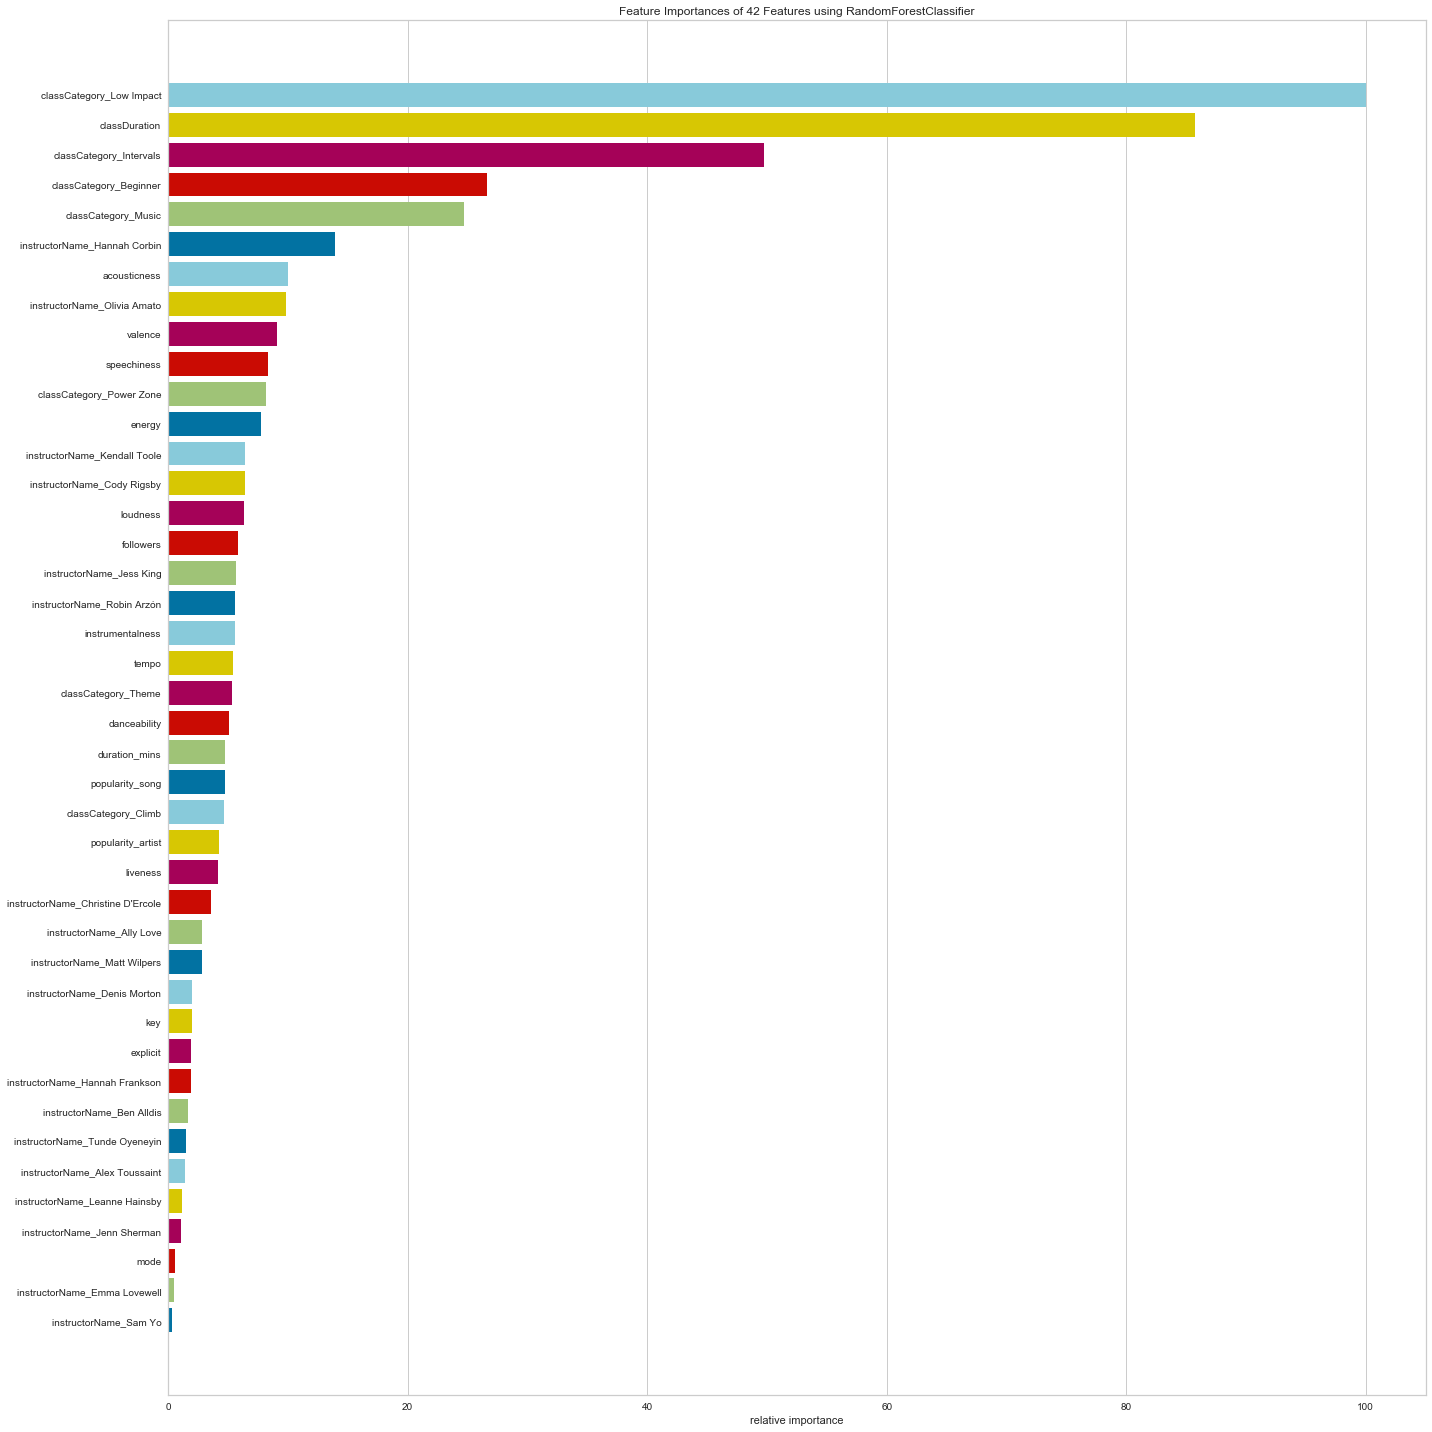

In [71]:
plt.figure(figsize=(20,20))
viz = FeatureImportances(tuned_rf8)
viz.fit(X, y)
viz.show()

#### Tuning RF - higher max features  and increase max depth again

In [73]:
tuned_rf9 = RandomForestClassifier(bootstrap = False,
                                  max_depth = 13, # increased 9 to 13
                                  max_features = 10, #increased 6 to 10
                                  min_samples_leaf = 1,
                                  min_samples_split = 20,
                                  n_estimators = 2000)

tuned_rf9.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=13, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

              precision    recall  f1-score   support

    Beginner       0.84      0.60      0.70       459
Intermediate       0.83      0.73      0.78       426
    Advanced       0.72      0.87      0.79       861

    accuracy                           0.77      1746
   macro avg       0.80      0.74      0.76      1746
weighted avg       0.78      0.77      0.76      1746

Train Scores
------------
Accuracy: 0.8926866526637388
F1 Score: 0.8926866526637388
--------------------
Test Scores
-----------
Accuracy: 0.7680412371134021
F1 Score: 0.7680412371134021
F1 Score Mean Cross Val 3-Fold: 0.7532939254795515


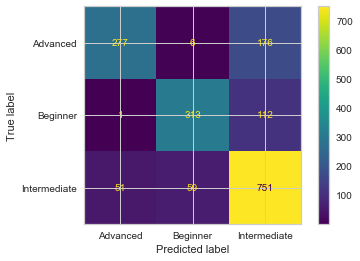

In [74]:
eval_model(tuned_rf9, X_train, X_test, y_train, y_test, ['Beginner', 'Intermediate', 'Advanced'], average='micro')
# too ovefit again...
# max features is definitely a culprit...

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


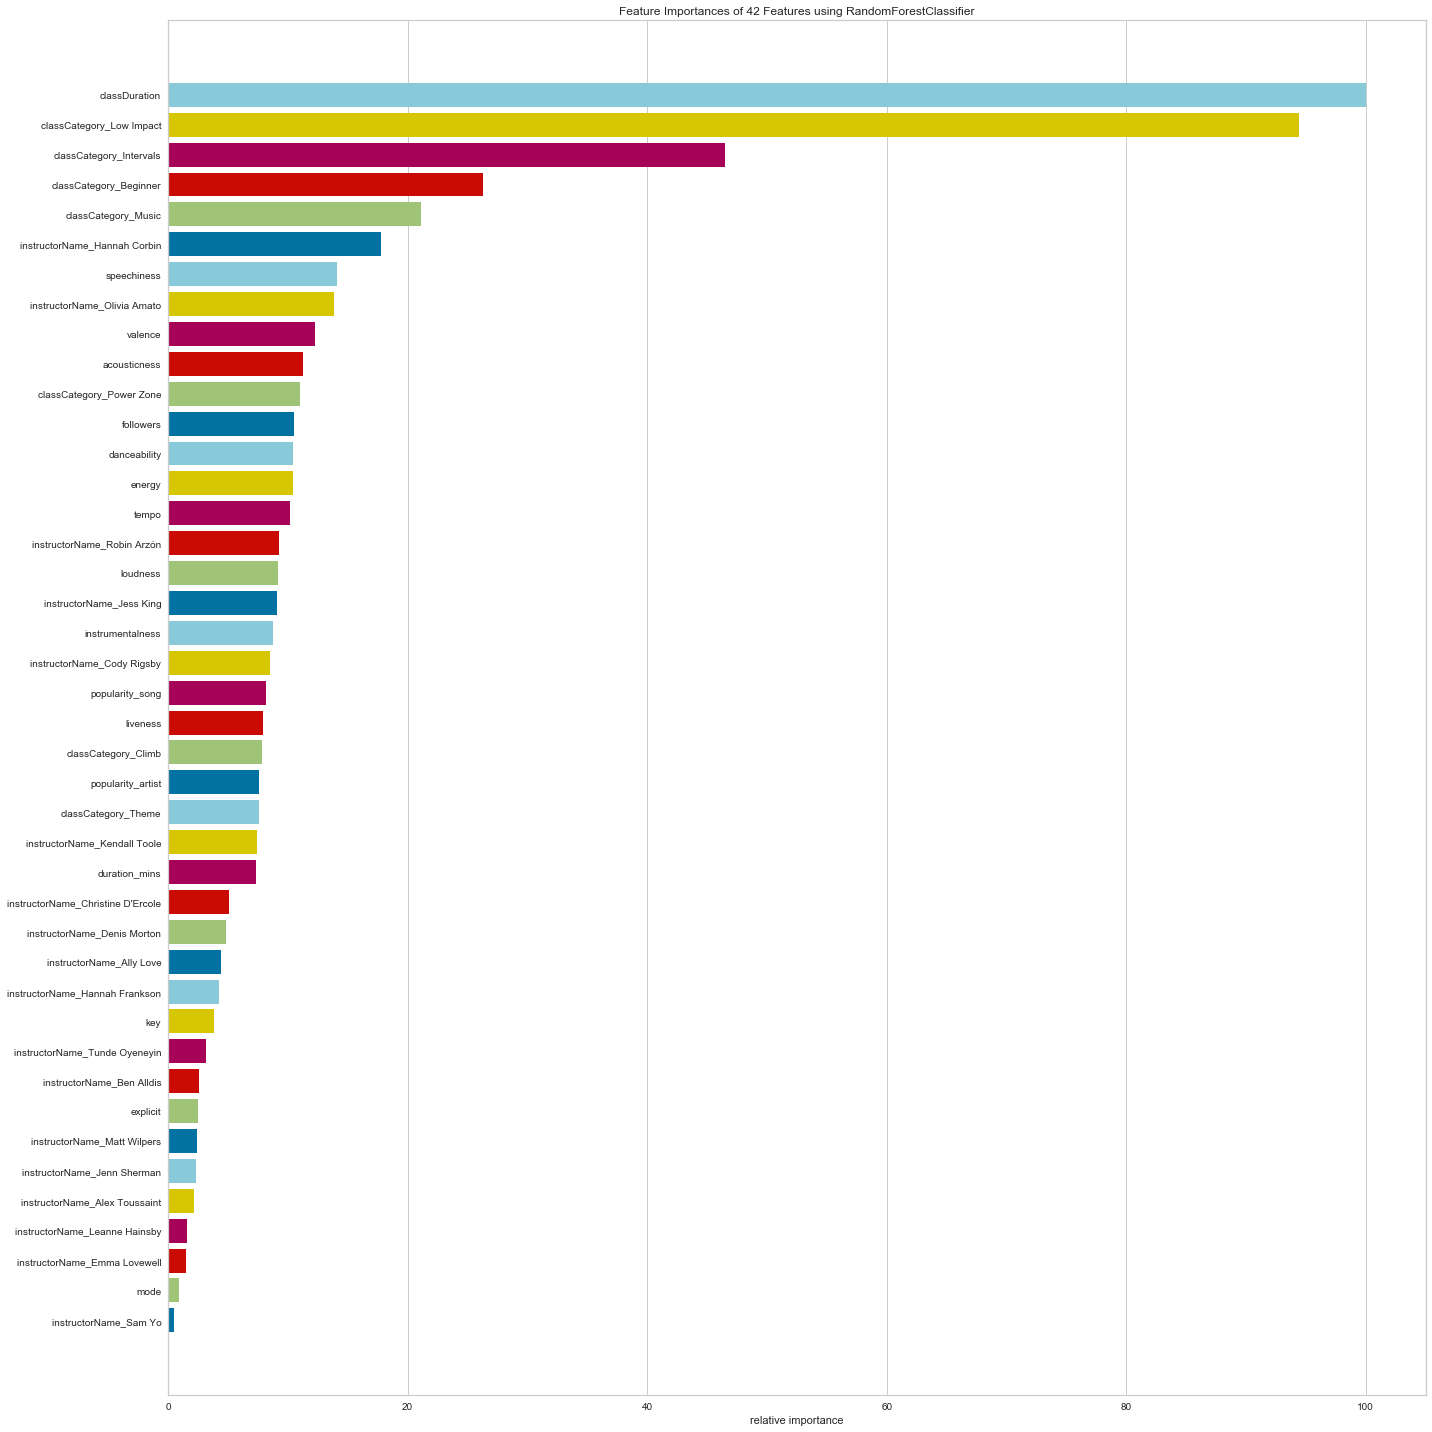

In [75]:
plt.figure(figsize=(20,20))
viz = FeatureImportances(tuned_rf9)
viz.fit(X, y)
viz.show()

#### Tuning RF - keep max features at 10 and decrease max depth again

In [76]:
tuned_rf10 = RandomForestClassifier(bootstrap = False,
                                  max_depth = 9, # decreased 9 back to 13
                                  max_features = 10, #stayed at 10
                                  min_samples_leaf = 1,
                                  min_samples_split = 20,
                                  n_estimators = 2000)

tuned_rf10.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

              precision    recall  f1-score   support

    Beginner       0.88      0.50      0.64       459
Intermediate       0.85      0.67      0.75       426
    Advanced       0.68      0.91      0.78       861

    accuracy                           0.74      1746
   macro avg       0.80      0.69      0.72      1746
weighted avg       0.78      0.74      0.74      1746

Train Scores
------------
Accuracy: 0.8075233912545351
F1 Score: 0.8075233912545351
--------------------
Test Scores
-----------
Accuracy: 0.7445589919816724
F1 Score: 0.7445589919816724
F1 Score Mean Cross Val 3-Fold: 0.7303799324092948


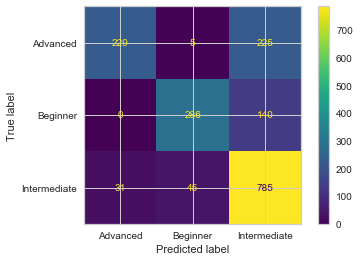

In [77]:
eval_model(tuned_rf10, X_train, X_test, y_train, y_test, ['Beginner', 'Intermediate', 'Advanced'], average='micro')
# MUCH less overfit again...
# acc + f1 at 74 not bad. 
# See if can decrease max features to 8 and decrease ovefitting even more

#### Tuning RF - decrease max features

In [78]:
tuned_rf11 = RandomForestClassifier(bootstrap = False,
                                  max_depth = 9, # stayed at 9
                                  max_features = 8, # decreased to 8
                                  min_samples_leaf = 1,
                                  min_samples_split = 20,
                                  n_estimators = 2000)

tuned_rf11.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

              precision    recall  f1-score   support

    Beginner       0.88      0.47      0.62       459
Intermediate       0.87      0.64      0.74       426
    Advanced       0.67      0.93      0.78       861

    accuracy                           0.74      1746
   macro avg       0.81      0.68      0.71      1746
weighted avg       0.78      0.74      0.73      1746

Train Scores
------------
Accuracy: 0.8059957991216345
F1 Score: 0.8059957991216345
--------------------
Test Scores
-----------
Accuracy: 0.7371134020618557
F1 Score: 0.7371134020618557
F1 Score Mean Cross Val 3-Fold: 0.7214058385328288


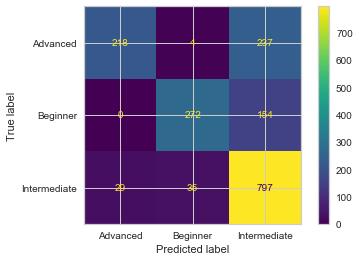

In [79]:
eval_model(tuned_rf11, X_train, X_test, y_train, y_test, ['Beginner', 'Intermediate', 'Advanced'], average='micro')
# same split and decreasing both train and test scores...

#### Tuning RF - try entropy instead of gini

In [80]:
tuned_rf12 = RandomForestClassifier(bootstrap = False,
                                  max_depth = 9, # stayed at 9
                                  max_features = 8, # decreased to 8
                                  min_samples_leaf = 1,
                                  min_samples_split = 20,
                                  n_estimators = 2000,
                                   criterion = 'entropy')

tuned_rf12.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=9, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

              precision    recall  f1-score   support

    Beginner       0.89      0.47      0.61       459
Intermediate       0.87      0.64      0.74       426
    Advanced       0.67      0.93      0.78       861

    accuracy                           0.74      1746
   macro avg       0.81      0.68      0.71      1746
weighted avg       0.78      0.74      0.72      1746

Train Scores
------------
Accuracy: 0.8023677678059958
F1 Score: 0.8023677678059958
--------------------
Test Scores
-----------
Accuracy: 0.7359679266895762
F1 Score: 0.7359679266895762
F1 Score Mean Cross Val 3-Fold: 0.7185402902089754


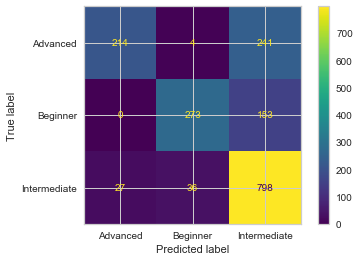

In [81]:
eval_model(tuned_rf12, X_train, X_test, y_train, y_test, ['Beginner', 'Intermediate', 'Advanced'], average='micro')
# not much difference
# slightly less overfit by 0.03

#### Tuning RF - Back to gini, Bootstrap = True

In [82]:
tuned_rf13 = RandomForestClassifier(max_depth = 9, # stayed at 9
                                  max_features = 8, # decreased to 8
                                  min_samples_leaf = 1,
                                  min_samples_split = 20,
                                  n_estimators = 2000)

tuned_rf13.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

              precision    recall  f1-score   support

    Beginner       0.88      0.46      0.61       459
Intermediate       0.89      0.61      0.72       426
    Advanced       0.66      0.93      0.78       861

    accuracy                           0.73      1746
   macro avg       0.81      0.67      0.70      1746
weighted avg       0.77      0.73      0.72      1746

Train Scores
------------
Accuracy: 0.7893832346763414
F1 Score: 0.7893832346763414
--------------------
Test Scores
-----------
Accuracy: 0.7308132875143184
F1 Score: 0.7308132875143185
F1 Score Mean Cross Val 3-Fold: 0.7143399950329913


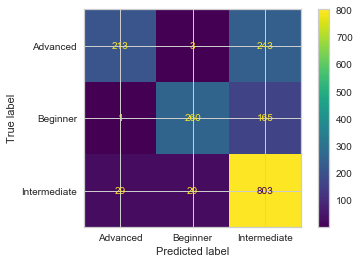

In [83]:
eval_model(tuned_rf13, X_train, X_test, y_train, y_test, ['Beginner', 'Intermediate', 'Advanced'], average='micro')
# WELL THAT DID IT...
# Go back sto max features and depths again. Try to raise these for highest f1 scores

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


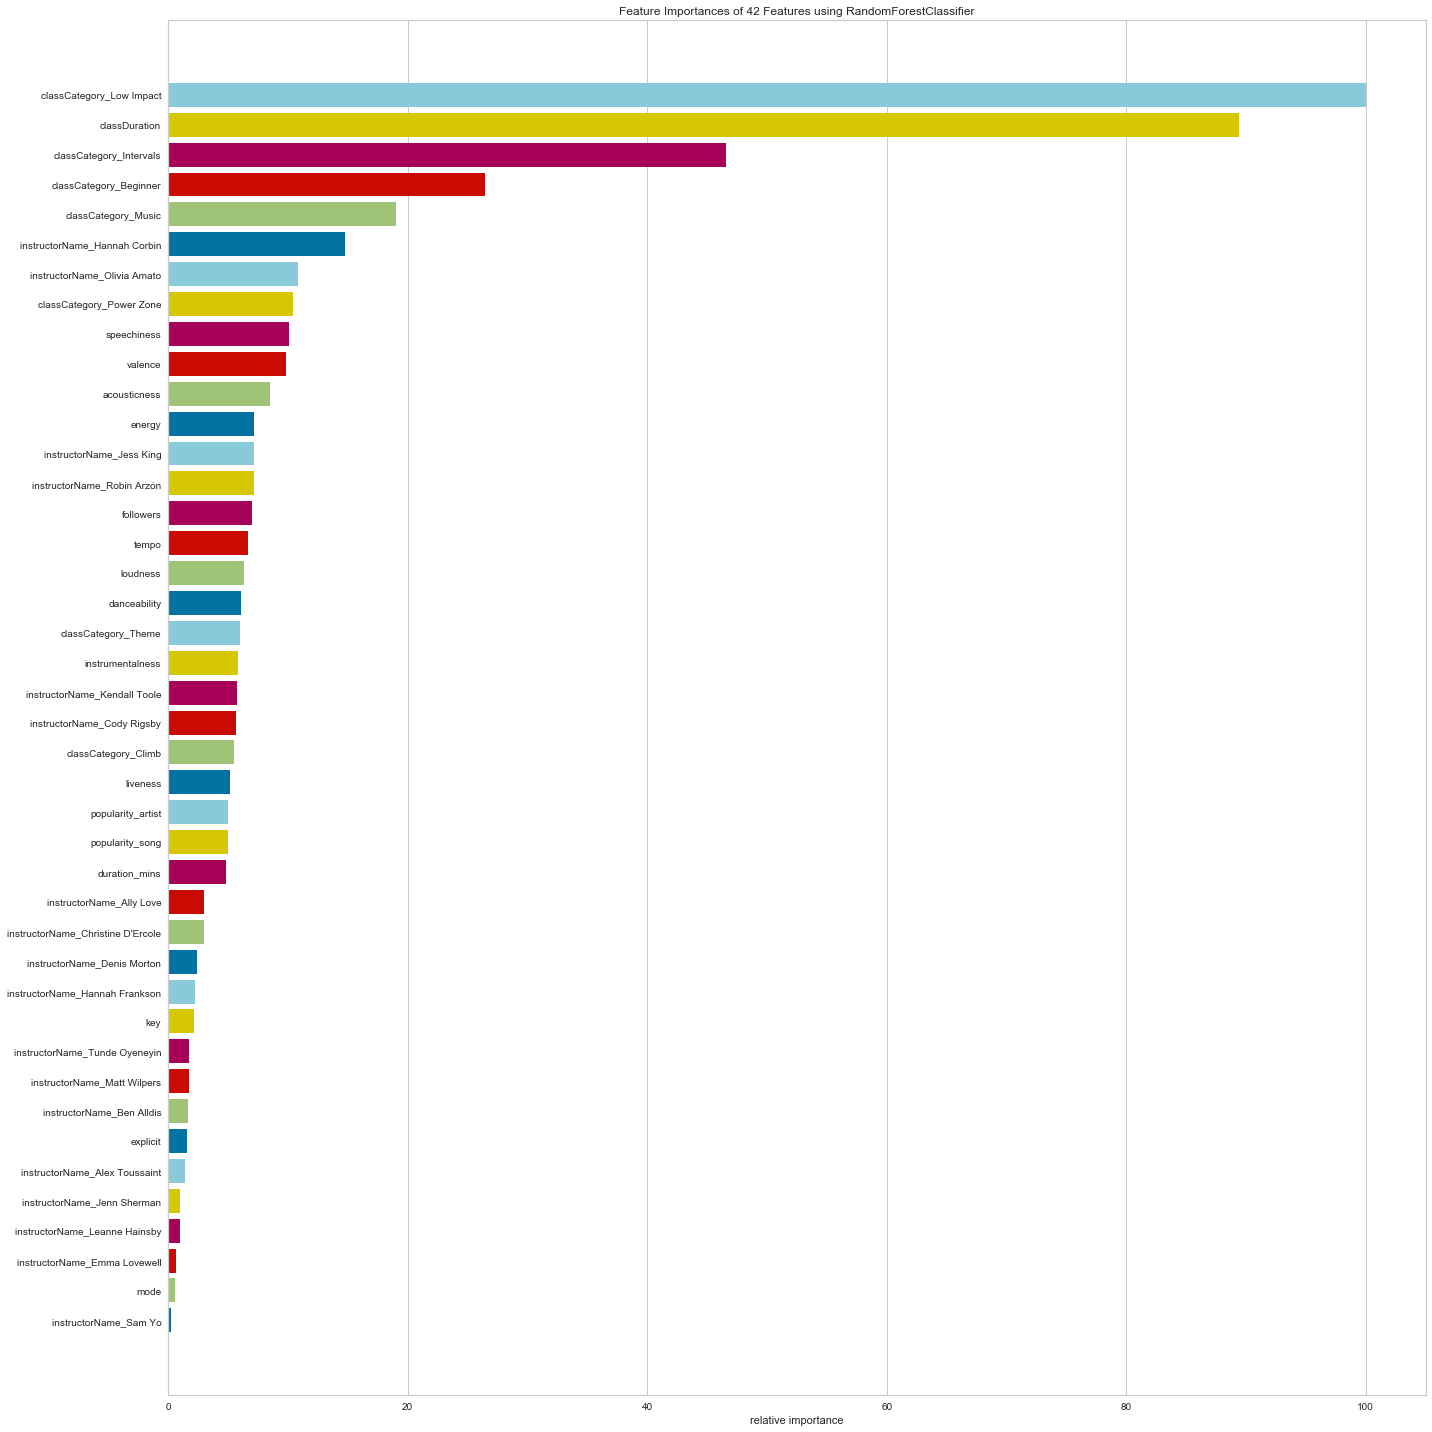

In [87]:
plt.figure(figsize=(20,20))
viz = FeatureImportances(tuned_rf13)
viz.fit(X, y)
viz.show()

#### Tuning RF - Try increasing max features again

In [85]:
tuned_rf14 = RandomForestClassifier(max_depth = 9, 
                                  max_features = 12, # increased 8 to 12
                                  min_samples_leaf = 1,
                                  min_samples_split = 20,
                                  n_estimators = 2000)

tuned_rf14.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features=12,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

              precision    recall  f1-score   support

    Beginner       0.88      0.51      0.65       459
Intermediate       0.86      0.67      0.75       426
    Advanced       0.68      0.91      0.78       861

    accuracy                           0.75      1746
   macro avg       0.81      0.70      0.73      1746
weighted avg       0.78      0.75      0.74      1746

Train Scores
------------
Accuracy: 0.8069505442046974
F1 Score: 0.8069505442046974
--------------------
Test Scores
-----------
Accuracy: 0.7474226804123711
F1 Score: 0.7474226804123713
F1 Score Mean Cross Val 3-Fold: 0.7284696033285524


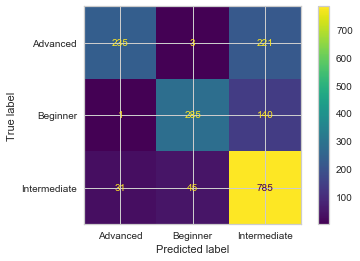

In [86]:
eval_model(tuned_rf14, X_train, X_test, y_train, y_test, ['Beginner', 'Intermediate', 'Advanced'], average='micro')
# More overfit
# back to rf10 level results 80/74
# try max features 10

#### Tuning RF - Back down to Max Features = 10

In [88]:
tuned_rf15 = RandomForestClassifier(max_depth = 9, 
                                  max_features = 10, # decreased 12 to 10
                                  min_samples_leaf = 1,
                                  min_samples_split = 20,
                                  n_estimators = 2000)

tuned_rf15.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## BEST FIT
least amount of overfitting...

              precision    recall  f1-score   support

    Beginner       0.88      0.50      0.63       459
Intermediate       0.87      0.64      0.74       426
    Advanced       0.68      0.92      0.78       861

    accuracy                           0.74      1746
   macro avg       0.81      0.69      0.72      1746
weighted avg       0.78      0.74      0.73      1746

Train Scores
------------
Accuracy: 0.7991216345235822
F1 Score: 0.7991216345235822
--------------------
Test Scores
-----------
Accuracy: 0.7416953035509737
F1 Score: 0.7416953035509738
F1 Score Mean Cross Val 3-Fold: 0.721977044542253


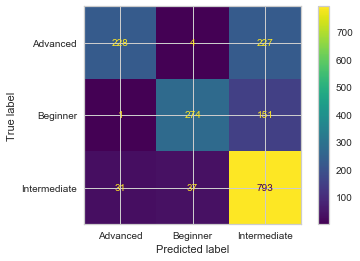

In [89]:
eval_model(tuned_rf15, X_train, X_test, y_train, y_test, ['Beginner', 'Intermediate', 'Advanced'], average='micro')
# Similar to tuned_rf13 in terms of overfitting, but higher scores
# Interesting notes:
## Beginner and Intermediate have best precision - avoiding false positive
## Advanced has best recall - avoiding false negative
## Beginner has worst f1

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


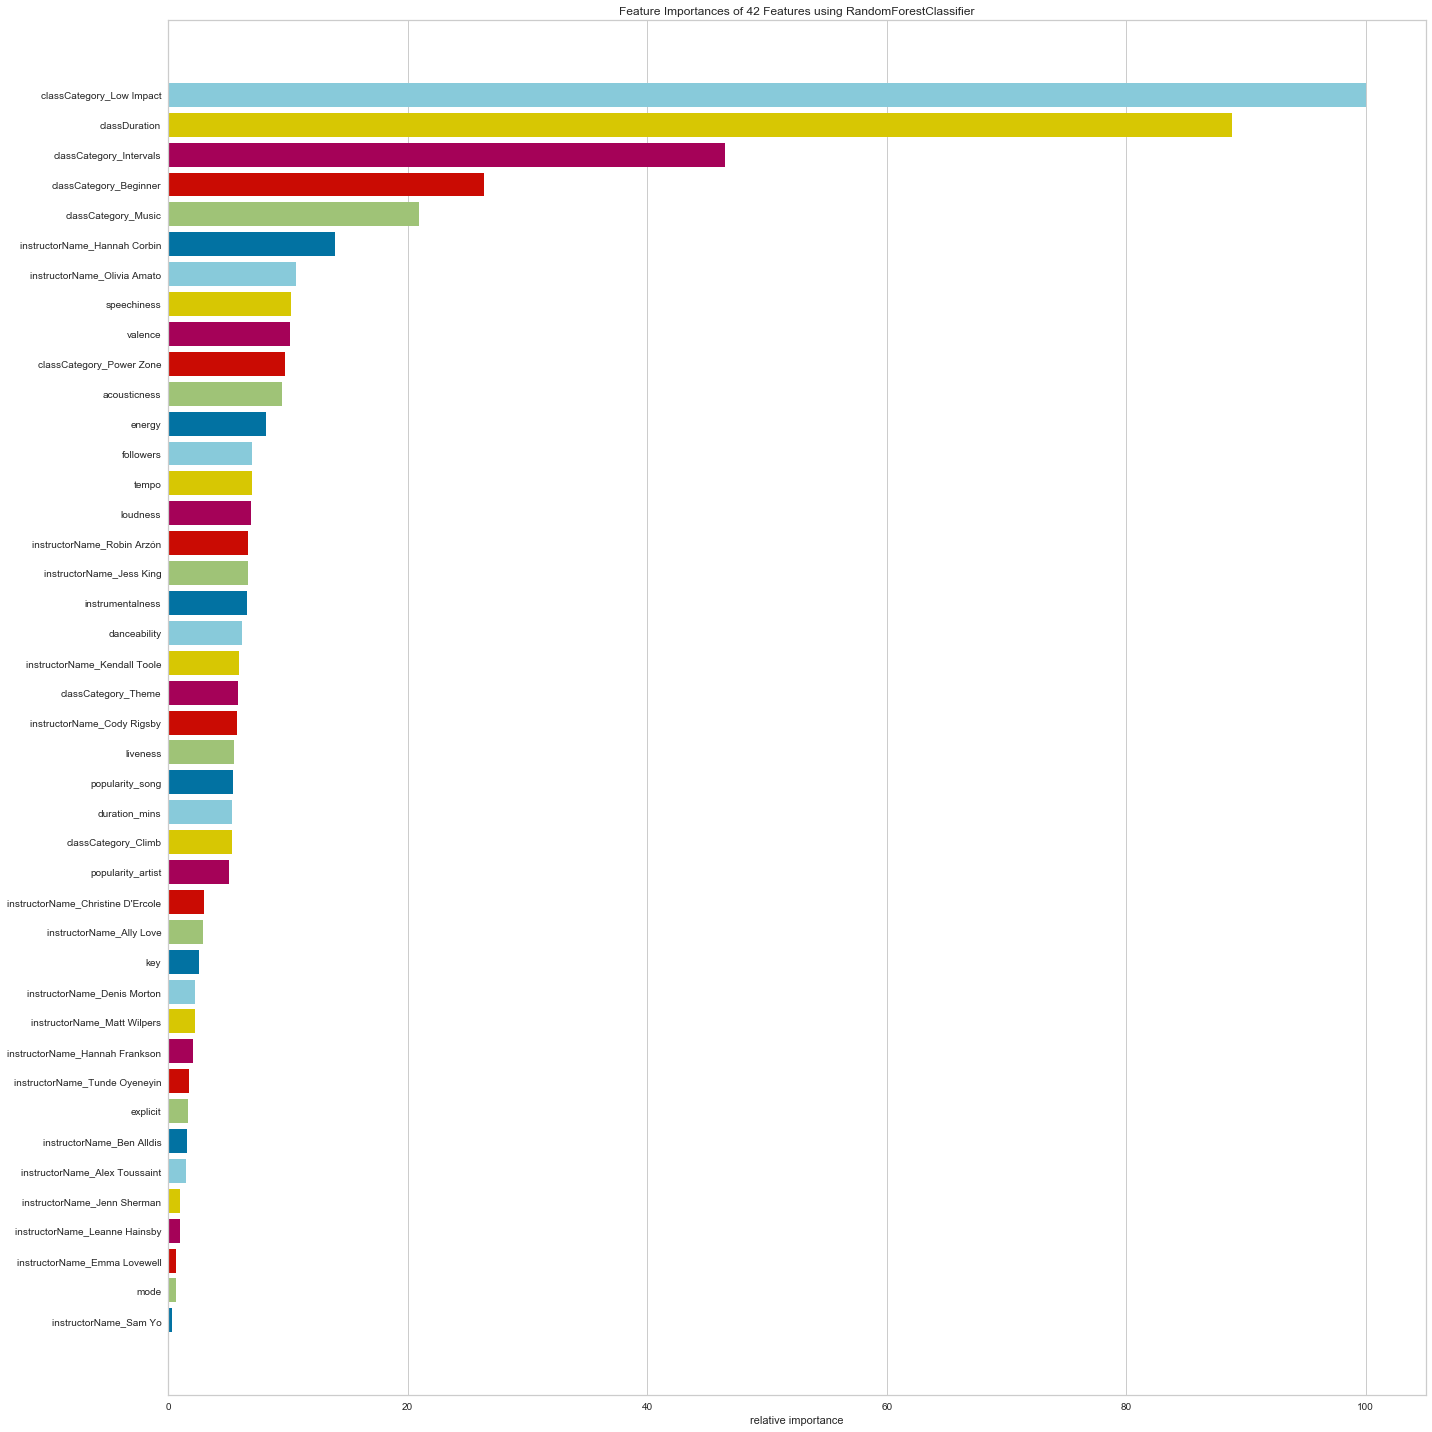

In [91]:
plt.figure(figsize=(20,20))
viz = FeatureImportances(tuned_rf15)
viz.fit(X, y)
viz.show()